## Comparison of Supervised Learning Algorithms 

Contained is the programmatic replication of the ideas contained in Caruana and Niculescu-Mizil's 2006 paper, "An Empirical Comparison of Supervised Learning Algorithms". 

This survey aims to compare the performance of four classifiers - Logistic Regression, Decision Tree, Neural Networks, and K-Nearest Neighbors - on three datasets from the UCI Machine Learning Repository. 

While the results are *consistent* with those of the paper, due to slight variations in the implementation, method, and tested metrics, the results do not directly mirror those of prior studies. 

Please note that the written report was completed with accuracies obtained once the code was complete. This kernel has been restarted since (to ensure functionality) so some accuracy outputs might deviate ever so slightly from those of the report, but overall trends will be preserved.

## Data Cleaning & Pre-Processing

Data Selection: 

- [Adult](http://archive.ics.uci.edu/ml/datasets/Adult) 
- [Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)
- [Occupancy Detection](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+) 

### Import General-Use Packages & Configure Environment

In [1]:
#Import General-Use Packages
import pandas as pd 
import numpy as np  
import scipy.io as sio 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import seaborn as sns
from datetime import datetime
import time
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#SciKit-Learn Packages
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Import Warnings Filter
from warnings import simplefilter
# Ignore All Future Warnings
simplefilter(action='ignore', category=FutureWarning)

### Pre-Processing: ADULT 

In [2]:
#Import 
adult_headers = ['age', 'workclass', 'fnlwgt','education', 'education-num', 'marital-status','occupation','relationship',\
                'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Above 50K']
adult_train = pd.read_csv('adult.data',header=None,names=adult_headers)
adult_test = pd.read_csv('adult.test',header=None,names=adult_headers,skiprows=[0])

#Combine Training/Testing Data 
adult = pd.concat([adult_train,adult_test])

#To Maintain Consistency Btwn. Train/Test, Remove '.' in Results
adult['Above 50K']=adult['Above 50K'].str.strip('.')

#Normalize - Change Numeric Values to Common Scale, w/o Distorting 
adult_norm = adult.select_dtypes(include=['int64','float64'])
adult_norm = (adult_norm-adult_norm.mean()) / (adult_norm.max() - adult_norm.min())
adult = pd.concat([adult_norm,adult.select_dtypes(exclude=['int64','float64'])],1)

#Ensure Numeric Features via Label Encoding 
adult['workclass'] = adult['workclass'].astype('category')
adult['workclass'] = adult['workclass'].cat.codes
adult['education'] = adult['education'].astype('category')
adult['education'] = adult['education'].cat.codes
adult['marital-status'] = adult['marital-status'].astype('category')
adult['marital-status'] = adult['marital-status'].cat.codes
adult['occupation'] = adult['occupation'].astype('category')
adult['occupation'] = adult['occupation'].cat.codes
adult['relationship'] = adult['relationship'].astype('category')
adult['relationship'] = adult['relationship'].cat.codes
adult['race'] = adult['race'].astype('category')
adult['race'] = adult['race'].cat.codes
adult['sex'] = adult['sex'].astype('category')
adult['sex'] = adult['sex'].cat.codes
adult['native-country'] = adult['native-country'].astype('category')
adult['native-country'] = adult['native-country'].cat.codes
adult['Above 50K'] = adult['Above 50K'].astype('category')
adult['Above 50K'] = adult['Above 50K'].cat.codes

#Shuffle 
adult = adult.sample(frac=1)

### Pre-Processing: WINE QUALITY

In [3]:
#Import 
wine_headers = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',\
               'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
white_wine = pd.read_csv('winequality-white.csv',header=None,names=wine_headers,skiprows=[0],sep=';')
red_wine = pd.read_csv('winequality-red.csv',header=None,names=wine_headers,skiprows=[0],sep=';')

#Combine Data 
wine = pd.concat([red_wine,white_wine])

#Normalize - Store Labels (Quality) 
wine_quality = wine['quality']
wine = (wine - wine.mean()) / (wine.max() - wine.min())
wine = wine.drop(['quality'],axis=1)
wine = pd.concat([wine,wine_quality],1)

#Shuffle
wine = wine.sample(frac=1)

### Pre-Processing: OCCUPANCY DETECTION

In [4]:
#Import 
occ_headers = ['no','date','Temperature','Humidity','Light','CO2', 'HumidityRatio','Occupancy']
occ_train = pd.read_csv('datatraining.txt',header=None,names=occ_headers,skiprows=[0])
occ_test1 = pd.read_csv('datatest.txt',header=None,names=occ_headers,skiprows=[0])
occ_test2 = pd.read_csv('datatest2.txt',header=None,names=occ_headers,skiprows=[0])

#Combine Training/Testing 
occ = pd.concat([occ_train,occ_test1,occ_test2])
occ.drop('no',axis=1,inplace=True)

#Interdependent Features - Better Performance without Normalizing 

#Ensure Numeric Features via Label Encoding
occ['date'] =occ['date'].astype('category')
occ['date'] = occ['date'].cat.codes
occ['Temperature'] = occ['Temperature'].astype('category')
occ['Temperature'] = occ['Temperature'].cat.codes
occ['Humidity'] = occ['Humidity'].astype('category')
occ['Humidity'] = occ['Humidity'].cat.codes
occ['Light'] = occ['Light'].astype('category')
occ['Light'] = occ['Light'].cat.codes
occ['CO2'] = occ['CO2'].astype('category')
occ['CO2'] = occ['CO2'].cat.codes
occ['HumidityRatio'] = occ['HumidityRatio'].astype('category')
occ['HumidityRatio'] = occ['HumidityRatio'].cat.codes
occ['Occupancy'] = occ['Occupancy'].astype('category')
occ['Occupancy'] = occ['Occupancy'].cat.codes

#Shuffle 
occ = occ.sample(frac =1)

### Partition Data 

In [5]:
#Partition each Set into X/Y 

#ADULT
X_adult = adult.iloc[:,:-1] #First Col to Second to Last Col: Features 
Y_adult = adult.iloc[:,-1] #Last Col: Labels 

#WINE
X_wine = wine.iloc[:,0:-1] #First Col to Second to Last Col: Features 
Y_wine = wine.iloc[:,-1] #Last Col: Labels

#OCCUPANCY 
X_occ = occ.iloc[:,:-1] #First to Second to Last Col: Features
Y_occ = occ.iloc[:,-1] #Last Col: Labels

In [6]:
#Change Labels to Binary Encoding 

#ADULT 
Y_adult = Y_adult.apply(lambda i: -1 if i <1 else 1)

#WINE 
Y_wine = Y_wine.apply(lambda i: -1 if i <6 else 1)

#OCCUPANCY 
Y_occ = Y_occ.apply(lambda i: -1 if i <1 else 1)

In [7]:
#PARTITION 1: 80 TRAIN /20 TEST

#ADULT 
X1_train_val_adult = X_adult[:int(.8*len(X_adult))] #Get Features from Train + Val Data 
X1_test_adult = X_adult[int(.8*len(X_adult)):] #Get Features from Test Data
Y1_train_val_adult = Y_adult[:int(.8*len(Y_adult))] #Get Labels from Train + Val Data
Y1_test_adult = Y_adult[int(.8*len(Y_adult)):] #Get Labels from Test Data 

#WINE 
X1_train_val_wine = X_wine[:int(.8*len(X_wine))]
X1_test_wine = X_wine[int(.8*len(X_wine)):]
Y1_train_val_wine = Y_wine[:int(0.8*len(Y_wine))]
Y1_test_wine = Y_wine[int(.8*len(Y_wine)):]

#OCCUPANCY
X1_train_val_occ = X_occ[:int(.8*len(X_occ))]
X1_test_occ = X_occ[int(.8*len(X_occ)):]
Y1_train_val_occ = Y_occ[:int(.8*len(Y_occ))]
Y1_test_occ = Y_occ[int(.8*len(Y_occ)):]

#Print out Shapes 
print('Adult:', X1_train_val_adult.shape, X1_test_adult.shape, Y1_train_val_adult.shape, Y1_test_adult.shape)
print('Wine:', X1_train_val_wine.shape, X1_test_wine.shape, Y1_train_val_wine.shape, Y1_test_wine.shape)
print('Occupancy:', X1_train_val_occ.shape, X1_test_occ.shape, Y1_train_val_occ.shape, Y1_test_occ.shape)

Adult: (39073, 14) (9769, 14) (39073,) (9769,)
Wine: (5197, 11) (1300, 11) (5197,) (1300,)
Occupancy: (16448, 6) (4112, 6) (16448,) (4112,)


In [8]:
#PARTITION 2: 50 TRAIN/50 TEST

#ADULT 
X2_train_val_adult = X_adult[:int(.5*len(X_adult))] #Get Features from Train + Val Data 
X2_test_adult = X_adult[int(.5*len(X_adult)):] #Get Features from Test Data
Y2_train_val_adult = Y_adult[:int(.5*len(Y_adult))] #Get Labels from Train + Val Data
Y2_test_adult = Y_adult[int(.5*len(Y_adult)):] #Get Labels from Test Data 

#WINE 
X2_train_val_wine = X_wine[:int(.5*len(X_wine))]
X2_test_wine = X_wine[int(.5*len(X_wine)):]
Y2_train_val_wine = Y_wine[:int(0.5*len(Y_wine))]
Y2_test_wine = Y_wine[int(.5*len(Y_wine)):]

#OCCUPANCY
X2_train_val_occ = X_occ[:int(.5*len(X_occ))]
X2_test_occ = X_occ[int(.5*len(X_occ)):]
Y2_train_val_occ = Y_occ[:int(.5*len(Y_occ))]
Y2_test_occ = Y_occ[int(.5*len(Y_occ)):]

#Print out Shapes 
print('Adult:', X2_train_val_adult.shape, X2_test_adult.shape, Y2_train_val_adult.shape, Y2_test_adult.shape)
print('Wine:', X2_train_val_wine.shape, X2_test_wine.shape, Y2_train_val_wine.shape, Y2_test_wine.shape)
print('Occupancy:', X2_train_val_occ.shape, X2_test_occ.shape, Y2_train_val_occ.shape, Y2_test_occ.shape)

Adult: (24421, 14) (24421, 14) (24421,) (24421,)
Wine: (3248, 11) (3249, 11) (3248,) (3249,)
Occupancy: (10280, 6) (10280, 6) (10280,) (10280,)


In [9]:
#PARTITION 3: 20 TRAIN /80 TEST

#ADULT 
X3_train_val_adult = X_adult[:int(.2*len(X_adult))] #Get Features from Train + Val Data 
X3_test_adult = X_adult[int(.2*len(X_adult)):] #Get Features from Test Data
Y3_train_val_adult = Y_adult[:int(.2*len(Y_adult))] #Get Labels from Train + Val Data
Y3_test_adult = Y_adult[int(.2*len(Y_adult)):] #Get Labels from Test Data 

#WINE 
X3_train_val_wine = X_wine[:int(.2*len(X_wine))]
X3_test_wine = X_wine[int(.2*len(X_wine)):]
Y3_train_val_wine = Y_wine[:int(0.2*len(Y_wine))]
Y3_test_wine = Y_wine[int(.2*len(Y_wine)):]

#OCCUPANCY
X3_train_val_occ = X_occ[:int(.2*len(X_occ))]
X3_test_occ = X_occ[int(.2*len(X_occ)):]
Y3_train_val_occ = Y_occ[:int(.2*len(Y_occ))]
Y3_test_occ = Y_occ[int(.2*len(Y_occ)):]

#Print out Shapes 
print('Adult:', X3_train_val_adult.shape, X3_test_adult.shape, Y3_train_val_adult.shape, Y3_test_adult.shape)
print('Wine:', X3_train_val_wine.shape, X3_test_wine.shape, Y3_train_val_wine.shape, Y3_test_wine.shape)
print('Occupancy:', X3_train_val_occ.shape, X3_test_occ.shape, Y3_train_val_occ.shape, Y3_test_occ.shape)

Adult: (9768, 14) (39074, 14) (9768,) (39074,)
Wine: (1299, 11) (5198, 11) (1299,) (5198,)
Occupancy: (4112, 6) (16448, 6) (4112,) (16448,)


## Logistic Regression 

### Import Packages

In [10]:
from sklearn.linear_model import LogisticRegression

### Implementation

In [11]:
#Draw Heatmaps
def draw_heatmap_logistic(acc, acc_desc, C_list, split):
    plt.figure(figsize = (9,5))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Train/Test Split', ylabel='$C$')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
def draw_heatmap_logistic_test(acc, acc_desc, split):
    plt.figure(figsize = (9,2))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels='')
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Train/Test Split', ylabel='accuracy')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
#Logistic Regression w/ Cross-Validation of 3
def LogReg(X1_train_pred, Y1_train_val, X2_train_pred, Y2_train_val, X3_train_pred, Y3_train_val,\
               X1_test, Y1_test, X2_test, Y2_test, X3_test, Y3_test, title1, title2, title3):
    
    LogReg = LogisticRegression(solver='liblinear', multi_class='ovr')
    C_list = (0.0001, 0.01, 1, 10, 100)
    train_test_split = ['80% Train 20% Test', '50% Train 50% Test', '20% Train 80% Test']
    
    grid_search_1 = GridSearchCV(LogReg, {'C': C_list},  cv = 3, return_train_score= True, iid = True)
    grid_search_1.fit(X1_train_pred, Y1_train_val)
    
    grid_search_2 = GridSearchCV(LogReg, {'C': C_list},  cv = 3, return_train_score= True, iid = True)
    grid_search_2.fit(X2_train_pred, Y2_train_val)
    
    grid_search_3 = GridSearchCV(LogReg, {'C': C_list},  cv = 3, return_train_score= True, iid = True)
    grid_search_3.fit(X3_train_pred, Y3_train_val)
    
    #Reporting Accuracy
    
    #TRAIN
    
    train_acc_1 = grid_search_1.cv_results_['mean_train_score']
    train_acc_2 = grid_search_2.cv_results_['mean_train_score']
    train_acc_3 = grid_search_3.cv_results_['mean_train_score']    
    train_acc = np.array([[train_acc_1],[train_acc_2], [train_acc_3]]).T
    train_acc = train_acc.reshape(5,3)
    draw_heatmap_logistic(train_acc,title1,C_list,train_test_split)
    
    #VALIDATION
    val_acc_1 = grid_search_1.cv_results_['mean_test_score'].reshape(5,1)
    val_acc_2 = grid_search_2.cv_results_['mean_test_score'].reshape(5,1)
    val_acc_3 = grid_search_3.cv_results_['mean_test_score'].reshape(5,1)
    val_acc = np.array([[val_acc_1],[val_acc_2],[val_acc_3]]).T
    val_acc = val_acc.reshape(5,3)
    draw_heatmap_logistic(val_acc,title2,C_list,train_test_split)
    
    
    #TEST 
    
    #First Prediction
    numcorrect = 0 
    pred_1 = grid_search_1.predict(X1_test)
    for i in range(len(pred_1)):
        if pred_1[i] != Y1_test.iloc[i]:
            numcorrect += 1
    test_acc_1 = 1-(numcorrect / len(pred_1))
    
    #Second Prediction 
    numcorrect = 0 
    pred_2 = grid_search_2.predict(X2_test)
    for i in range(len(pred_2)): 
        if pred_2[i] != Y2_test.iloc[i]:
            numcorrect += 1
    test_acc_2 = 1-(numcorrect/len(pred_2))
    
    #Third Prediction 
    numcorrect = 0 
    pred_3 = grid_search_3.predict(X3_test)
    for i in range(len(pred_3)):
        if pred_3[i] != Y3_test.iloc[i]:
            numcorrect += 1
    test_acc_3 = 1-(numcorrect/len(pred_3))
    
    #Combine and Display 
    test_acc = np.array([[test_acc_1],[test_acc_2],[test_acc_3]]).reshape(1,3)
    draw_heatmap_logistic_test(test_acc,title3,train_test_split)
    
    #Handle Multiple Iterations, Outputting Avg. Results 
    LR_Dictionary = {}
    LR_Dictionary['80/20 Split Train'] = np.mean(train_acc_1)
    LR_Dictionary['50/50 Split Train'] = np.mean(train_acc_2)
    LR_Dictionary['20/80 Split Train'] = np.mean(train_acc_3)
    LR_Dictionary['80/20 Split Validation'] = np.mean(val_acc_1)
    LR_Dictionary['50/50 Split Validation'] = np.mean(val_acc_2)
    LR_Dictionary['20/80 Split Validation'] = np.mean(val_acc_3)
    LR_Dictionary['80/20 Split Test'] = test_acc_1
    LR_Dictionary['50/50 Split Test'] = test_acc_2
    LR_Dictionary['20/80 Split Test'] = test_acc_3
    return LR_Dictionary

### Hold Results

In [12]:
LR_adult_average_test = 0
LR_wine_average_test = 0
LR_occ_average_test = 0 


LR_overall_average = []

#80/20 Split Average
LR1_average = []
#50/50 Split Average 
LR2_average = []
#20/80 Split Average 
LR3_average = []

### Results 

#### Logistic Regression - ADULT 

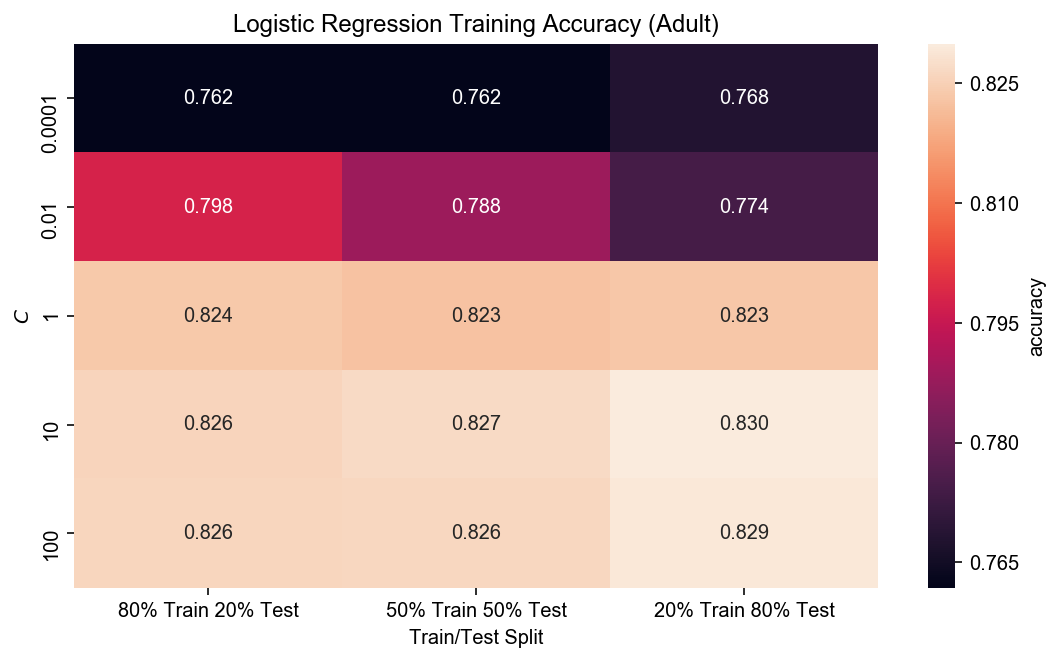

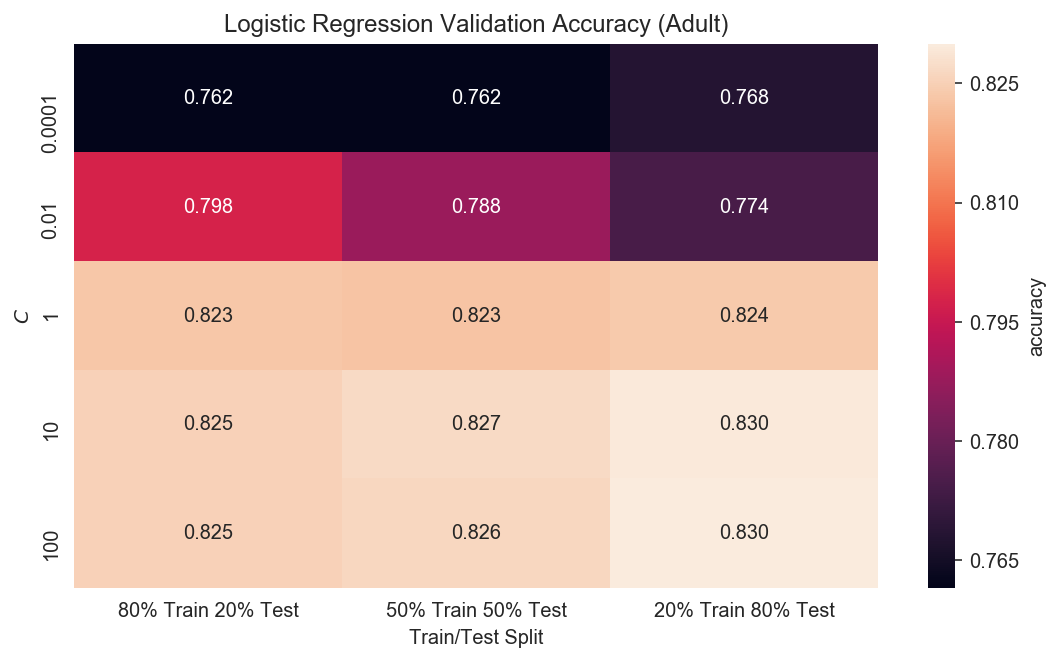

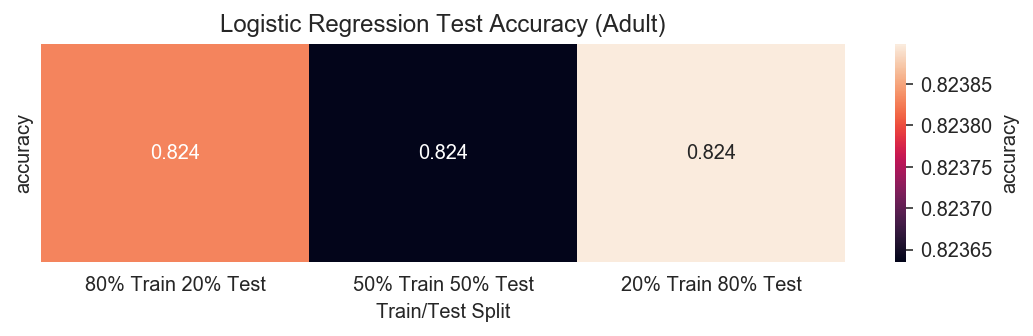

In [13]:
LR_adult = LogReg(X1_train_val_adult, Y1_train_val_adult,X2_train_val_adult,
                  Y2_train_val_adult,  X3_train_val_adult, Y3_train_val=Y3_train_val_adult,X1_test=X1_test_adult, Y1_test=Y1_test_adult,
                  X2_test=X2_test_adult,Y2_test=Y2_test_adult,X3_test=X3_test_adult, Y3_test=Y3_test_adult, 
                 title1='Logistic Regression Training Accuracy (Adult)', 
                 title2='Logistic Regression Validation Accuracy (Adult)', 
                 title3='Logistic Regression Test Accuracy (Adult)')

In [14]:
#Fill with Output After Fitting Data 
LR_overall_average.append(np.mean(list(LR_adult.values())))

hold = [] 
hold.append(LR_adult['80/20 Split Train'])
hold.append(LR_adult['80/20 Split Validation'])
hold.append(LR_adult['80/20 Split Test'])
LR1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(LR_adult['50/50 Split Train'])
hold.append(LR_adult['50/50 Split Validation'])
hold.append(LR_adult['50/50 Split Test'])
LR2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(LR_adult['20/80 Split Train'])
hold.append(LR_adult['20/80 Split Validation'])
hold.append(LR_adult['20/80 Split Test'])
LR3_average.append(np.mean(np.array(hold)))

LR_adult_average_test = np.mean(np.array(hold))

#### Logistic Regression - WINE

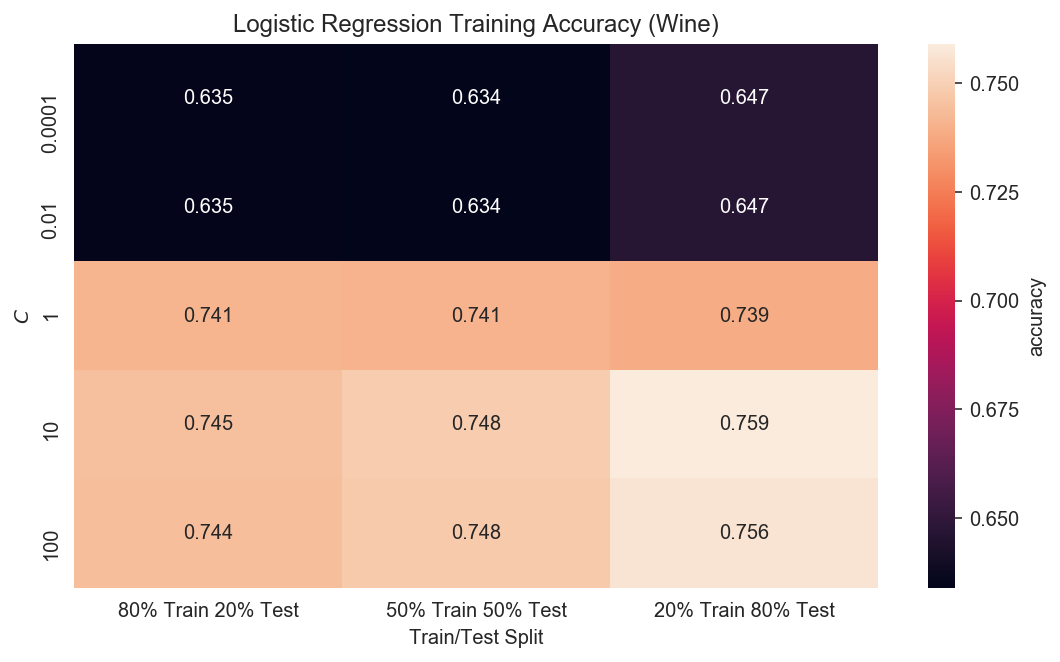

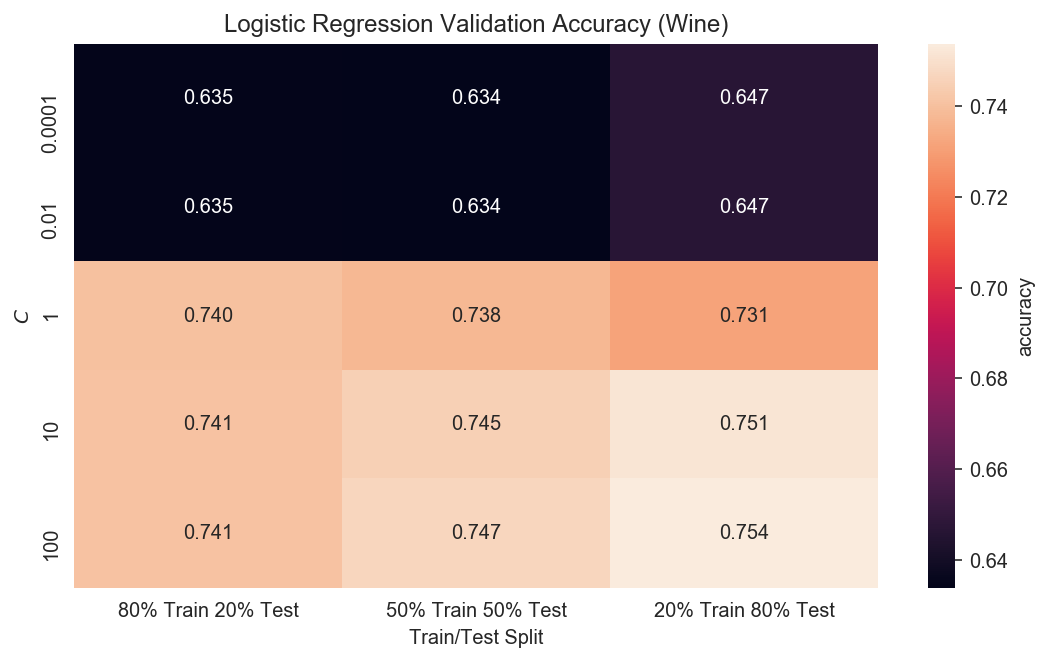

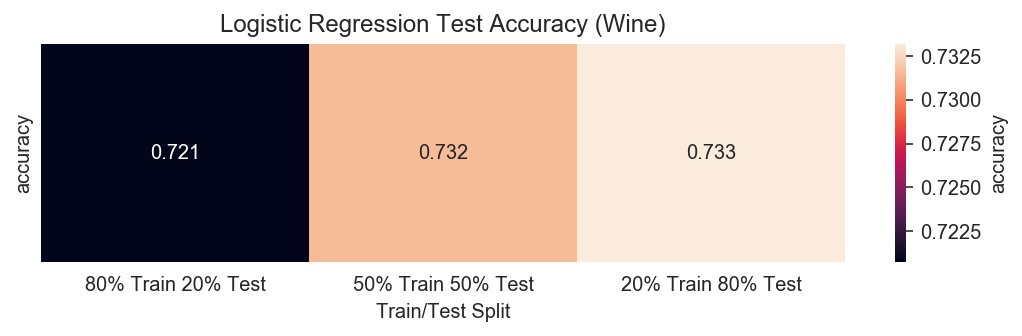

In [15]:
LR_wine = LogReg(X1_train_val_wine, Y1_train_val_wine,X2_train_val_wine, Y2_train_val_wine,
            X3_train_val_wine, Y3_train_val_wine,X1_test_wine, Y1_test_wine, 
            X2_test_wine, Y2_test_wine,X3_test_wine, Y3_test_wine,
            'Logistic Regression Training Accuracy (Wine)', 
            'Logistic Regression Validation Accuracy (Wine)', 
            'Logistic Regression Test Accuracy (Wine)')

In [16]:
#Fill with Output After Fitting Data 
LR_overall_average.append(np.mean(list(LR_adult.values())))

hold = [] 
hold.append(LR_wine['80/20 Split Train'])
hold.append(LR_wine['80/20 Split Validation'])
hold.append(LR_wine['80/20 Split Test'])
LR1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(LR_wine['50/50 Split Train'])
hold.append(LR_wine['50/50 Split Validation'])
hold.append(LR_wine['50/50 Split Test'])
LR2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(LR_wine['20/80 Split Train'])
hold.append(LR_wine['20/80 Split Validation'])
hold.append(LR_wine['20/80 Split Test'])
LR3_average.append(np.mean(np.array(hold)))

LR_wine_average_test = np.mean(np.array(hold))

#### Logistic Regression - OCCUPANCY

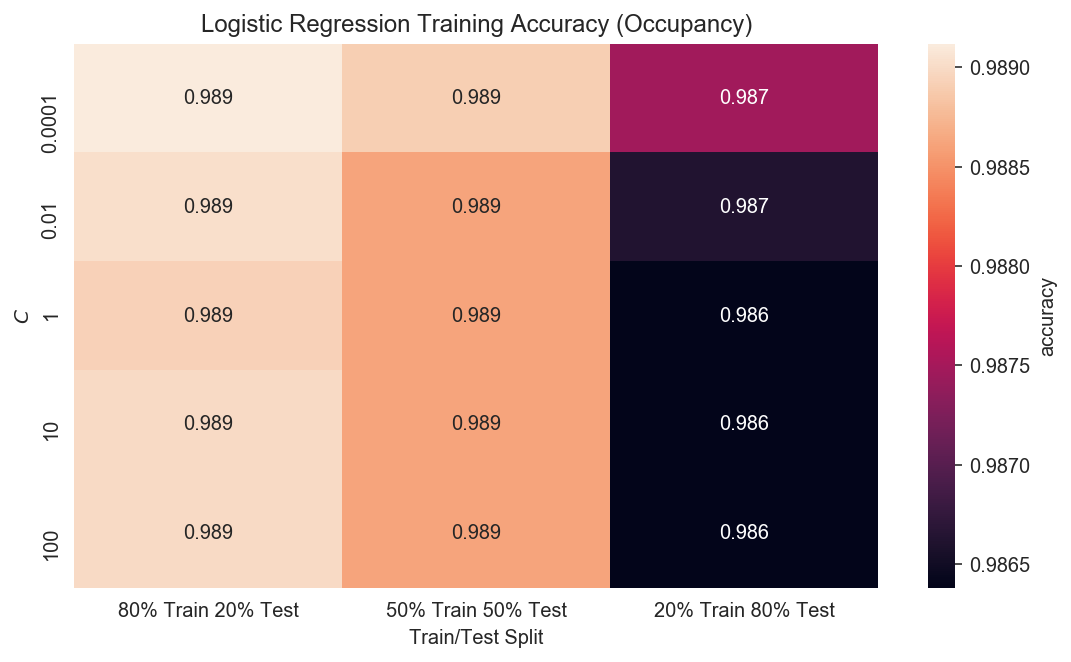

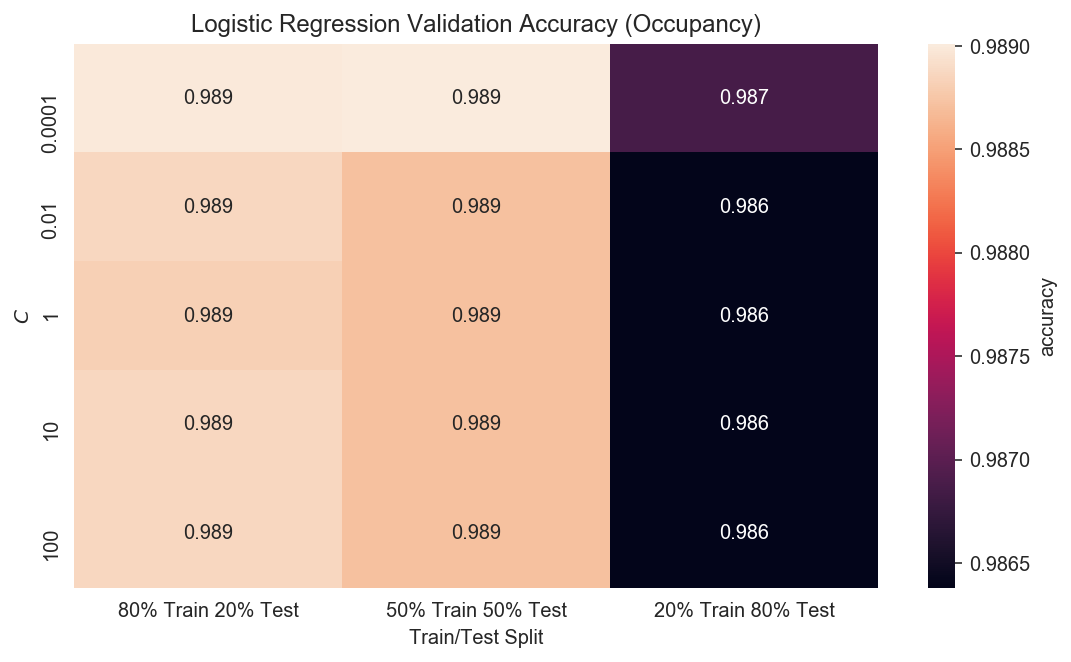

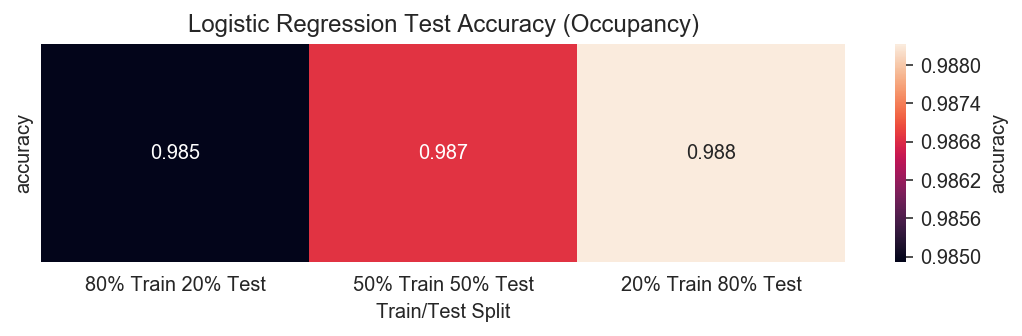

In [17]:
LR_occ = LogReg(X1_train_val_occ, Y1_train_val_occ,X2_train_val_occ, Y2_train_val_occ,
            X3_train_val_occ, Y3_train_val_occ,X1_test_occ, Y1_test_occ, 
            X2_test_occ, Y2_test_occ,X3_test_occ, Y3_test_occ,
            'Logistic Regression Training Accuracy (Occupancy)', 
            'Logistic Regression Validation Accuracy (Occupancy)', 
            'Logistic Regression Test Accuracy (Occupancy)')

In [18]:
#Fill with Output After Fitting Data 
LR_overall_average.append(np.mean(list(LR_occ.values())))

hold = [] 
hold.append(LR_occ['80/20 Split Train'])
hold.append(LR_occ['80/20 Split Validation'])
hold.append(LR_occ['80/20 Split Test'])
LR1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(LR_occ['50/50 Split Train'])
hold.append(LR_occ['50/50 Split Validation'])
hold.append(LR_occ['50/50 Split Test'])
LR2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(LR_occ['20/80 Split Train'])
hold.append(LR_occ['20/80 Split Validation'])
hold.append(LR_occ['20/80 Split Test'])
LR3_average.append(np.mean(np.array(hold)))

LR_occ_average_test = np.mean(np.array(hold))

## Decision Tree 

### Import Packages 

In [19]:
from sklearn.tree import DecisionTreeClassifier

### Implementation

In [20]:
#Draw Heatmaps
def draw_heatmap_tree(acc, acc_desc, depth_list, split):
    plt.figure(figsize = (9,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=depth_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Train/Test Split', ylabel='$max depth$')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
def draw_heatmap_tree_test(acc, acc_desc, split):
    plt.figure(figsize = (9,2))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels='')
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Train/Test Split', ylabel='accuracy')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
#Decision Tree Classifier with Cross-Validation of 3 
def DecisionTree(X1_train_pred, Y1_train_val, X2_train_pred, Y2_train_val, X3_train_pred, Y3_train_val,\
               X1_test, Y1_test, X2_test, Y2_test, X3_test, Y3_test, title1, title2, title3):
    maxdepth = [1,2,3,4,5]
    
    tree = DecisionTreeClassifier(criterion='entropy')
    train_test_split = ['80% Train 20% Test', '50% Train 50% Test','20% Train 80% Test']
    
    grid_search_1 = GridSearchCV(tree,{'max_depth':maxdepth}, cv=3,return_train_score=True, iid=False)
    grid_search_1.fit(X1_train_pred,Y1_train_val)
    
    grid_search_2 = GridSearchCV(tree,{'max_depth':maxdepth}, cv=3,return_train_score=True, iid=False)
    grid_search_2.fit(X2_train_pred,Y2_train_val)
    
    grid_search_3 = GridSearchCV(tree,{'max_depth':maxdepth}, cv=3,return_train_score=True, iid=False)
    grid_search_3.fit(X3_train_pred,Y3_train_val)
    
    #Reporting Accuracy 
    
    #TRAIN 
    train_acc_1 = grid_search_1.cv_results_['mean_train_score'].reshape(5,1)
    train_acc_2 = grid_search_2.cv_results_['mean_train_score'].reshape(5,1)
    train_acc_3 = grid_search_3.cv_results_['mean_train_score'].reshape(5,1)
    
    train_acc = np.array([[train_acc_1],[train_acc_2],[train_acc_3]]).T 
    train_acc = train_acc.reshape(5,3)
    draw_heatmap_tree(train_acc,title1,maxdepth,train_test_split)
    
    #VALIDATION 
    val_acc_1 = grid_search_1.cv_results_['mean_train_score'].reshape(5,1)
    val_acc_2 = grid_search_2.cv_results_['mean_train_score'].reshape(5,1)
    val_acc_3 = grid_search_3.cv_results_['mean_train_score'].reshape(5,1)
    
    val_acc = np.array([[val_acc_1],[val_acc_2],[val_acc_3]]).T 
    val_acc = val_acc.reshape(5,3)
    draw_heatmap_tree(val_acc,title2,maxdepth,train_test_split)
    
    #TEST 
    
    #First Prediction
    numcorrect = 0
    pred_1 = grid_search_1.predict(X1_test)
    for i in range(len(pred_1)):
        if pred_1[i] != Y1_test.iloc[i]:
            numcorrect += 1
    test_acc_1 = 1-(numcorrect / len(pred_1))
    
    #Second Prediction 
    numcorrect = 0
    pred_2 = grid_search_2.predict(X2_test)
    for i in range(len(pred_2)):
        if pred_2[i] != Y2_test.iloc[i]:
            numcorrect += 1
    test_acc_2 = 1-(numcorrect / len(pred_2))
    
    #Third Prediction
    numcorrect = 0
    pred_3 = grid_search_3.predict(X3_test)
    for i in range(len(pred_3)):
        if pred_3[i] != Y3_test.iloc[i]:
            numcorrect += 1
    test_acc_3 = 1-(numcorrect / len(pred_3))
    
    #Combine and Display
    test_acc = np.array([[test_acc_1], [test_acc_2], [test_acc_3]]).reshape(1,3)
    draw_heatmap_tree_test(test_acc, title3, train_test_split)
    
    #Handle Multiple Interations, Outputting Average Results 
    treeDict = {}
    treeDict['80/20 Split Train'] = np.mean(train_acc_1)
    treeDict['50/50 Split Train'] = np.mean(train_acc_2)
    treeDict['20/80 Split Train'] = np.mean(train_acc_3)
    treeDict['80/20 Split Validation'] = np.mean(val_acc_1)
    treeDict['50/50 Split Validation'] = np.mean(val_acc_2)
    treeDict['20/80 Split Validation'] = np.mean(val_acc_3)
    treeDict['80/20 Split Test'] = test_acc_1
    treeDict['50/50 Split Test'] = test_acc_2
    treeDict['20/80 Split Test'] = test_acc_3
    return treeDict

### Hold Results

In [21]:
tree_adult_average_test = 0
tree_wine_average_test =0
tree_occ_average_test=0

tree_overall_average = []

tree1_average = []
tree2_average = []
tree3_average = []

### Results

#### Decision Tree - ADULT

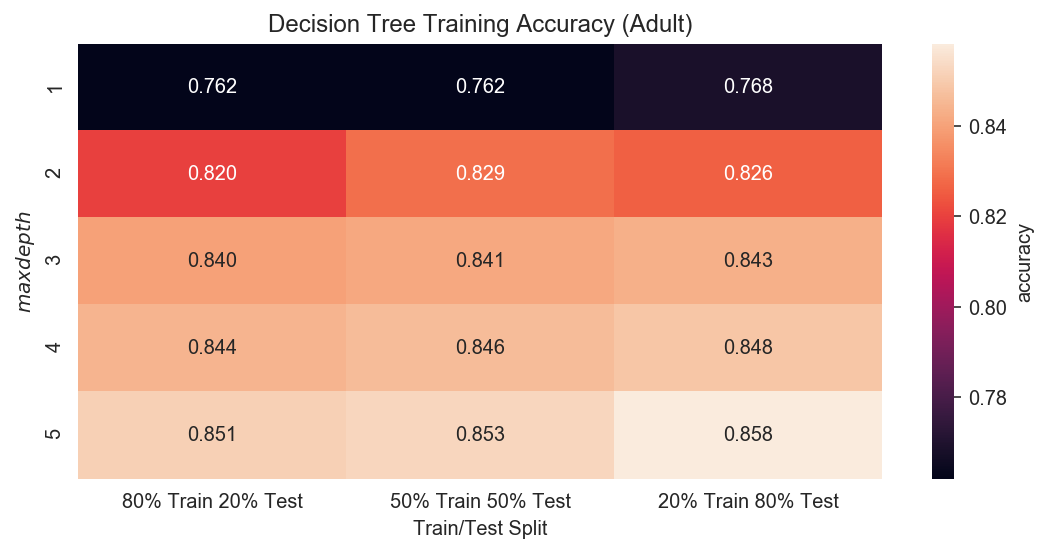

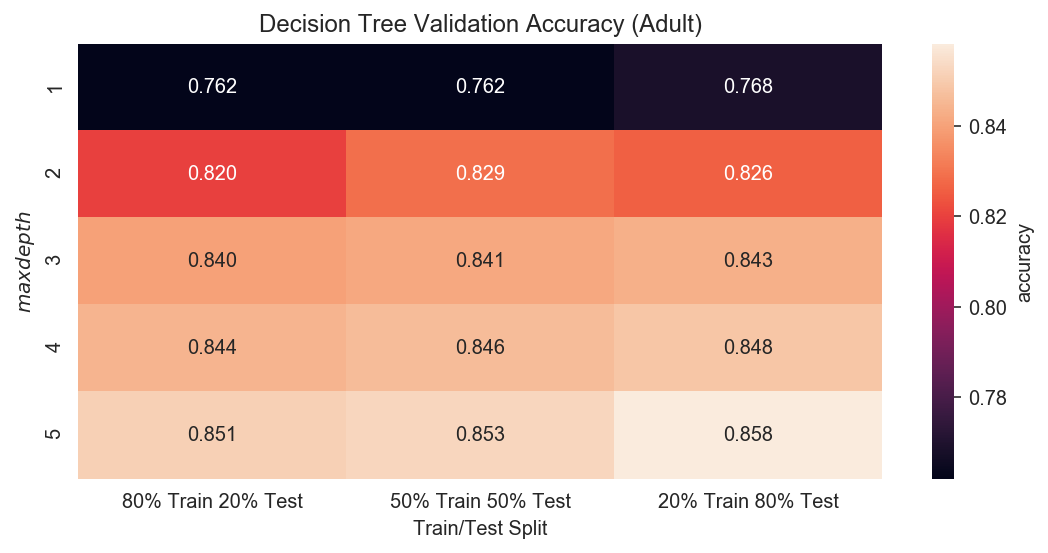

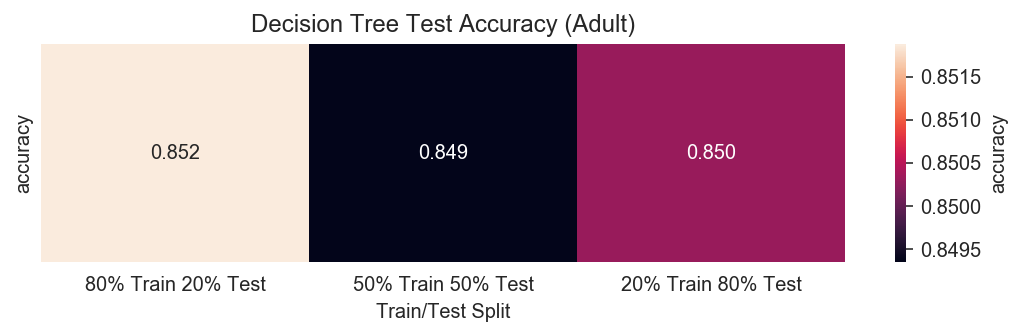

In [22]:
tree_adult = DecisionTree(X1_train_val_adult, Y1_train_val_adult,X2_train_val_adult,
                  Y2_train_val_adult,  X3_train_val_adult, Y3_train_val=Y3_train_val_adult,X1_test=X1_test_adult, Y1_test=Y1_test_adult,
                  X2_test=X2_test_adult,Y2_test=Y2_test_adult,X3_test=X3_test_adult, Y3_test=Y3_test_adult, 
                 title1='Decision Tree Training Accuracy (Adult)', 
                 title2='Decision Tree Validation Accuracy (Adult)', 
                 title3='Decision Tree Test Accuracy (Adult)')

In [23]:
#Fill with Output After Fitting Data 
tree_overall_average.append(np.mean(list(tree_adult.values())))

hold = [] 
hold.append(tree_adult['80/20 Split Train'])
hold.append(tree_adult['80/20 Split Validation'])
hold.append(tree_adult['80/20 Split Test'])
tree1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(tree_adult['50/50 Split Train'])
hold.append(tree_adult['50/50 Split Validation'])
hold.append(tree_adult['50/50 Split Test'])
tree2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(tree_adult['20/80 Split Train'])
hold.append(tree_adult['20/80 Split Validation'])
hold.append(tree_adult['20/80 Split Test'])
tree3_average.append(np.mean(np.array(hold)))

tree_adult_average_test = np.mean(np.array(hold))

#### Decision Tree - WINE 

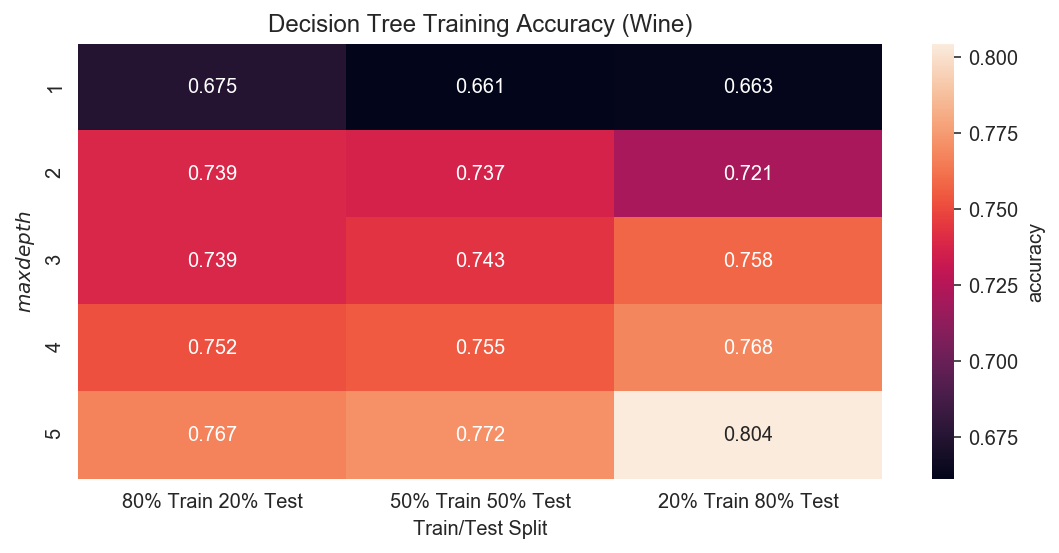

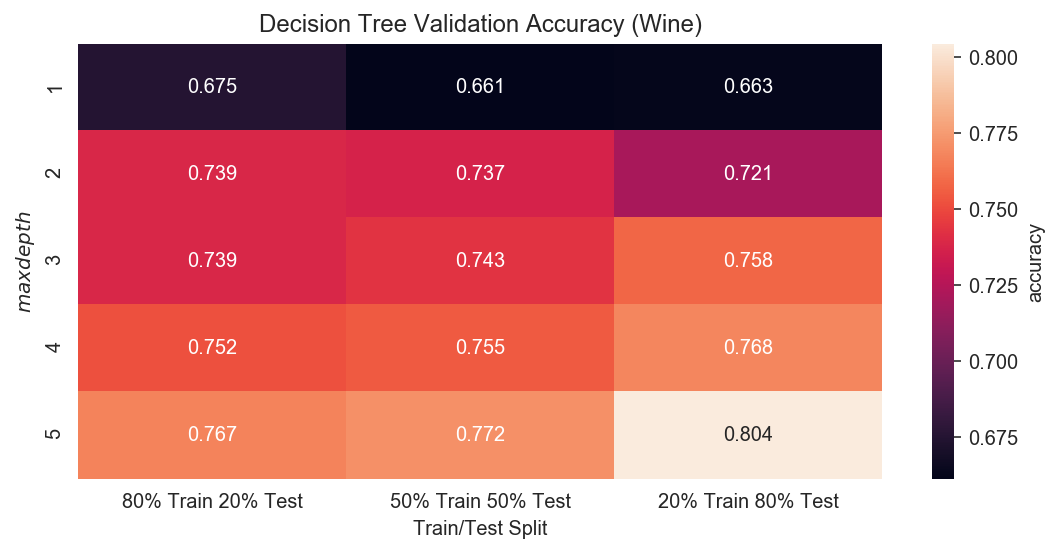

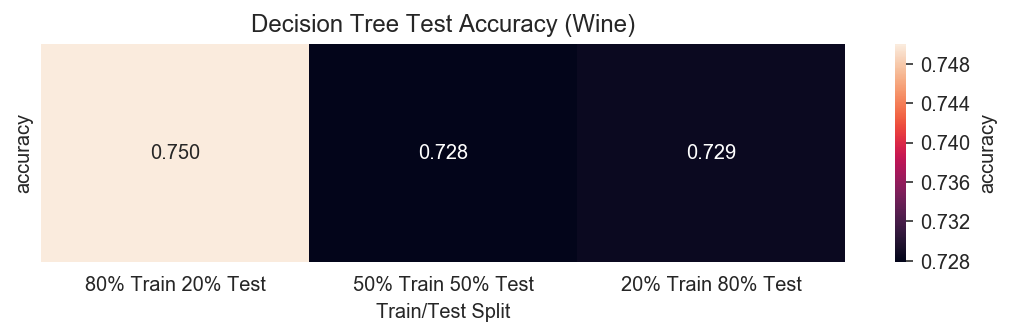

In [24]:
tree_wine = DecisionTree(X1_train_val_wine, Y1_train_val_wine,X2_train_val_wine, Y2_train_val_wine,
            X3_train_val_wine, Y3_train_val_wine,X1_test_wine, Y1_test_wine, 
            X2_test_wine, Y2_test_wine,X3_test_wine, Y3_test_wine,
            'Decision Tree Training Accuracy (Wine)', 
            'Decision Tree Validation Accuracy (Wine)', 
            'Decision Tree Test Accuracy (Wine)')

In [25]:
#Fill with Output After Fitting Data 
tree_overall_average.append(np.mean(list(tree_wine.values())))

hold = [] 
hold.append(tree_wine['80/20 Split Train'])
hold.append(tree_wine['80/20 Split Validation'])
hold.append(tree_wine['80/20 Split Test'])
tree1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(tree_wine['50/50 Split Train'])
hold.append(tree_wine['50/50 Split Validation'])
hold.append(tree_wine['50/50 Split Test'])
tree2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(tree_wine['20/80 Split Train'])
hold.append(tree_wine['20/80 Split Validation'])
hold.append(tree_wine['20/80 Split Test'])
tree3_average.append(np.mean(np.array(hold)))

tree_wine_average_test = np.mean(np.array(hold))

#### Decision Tree - OCCUPANCY

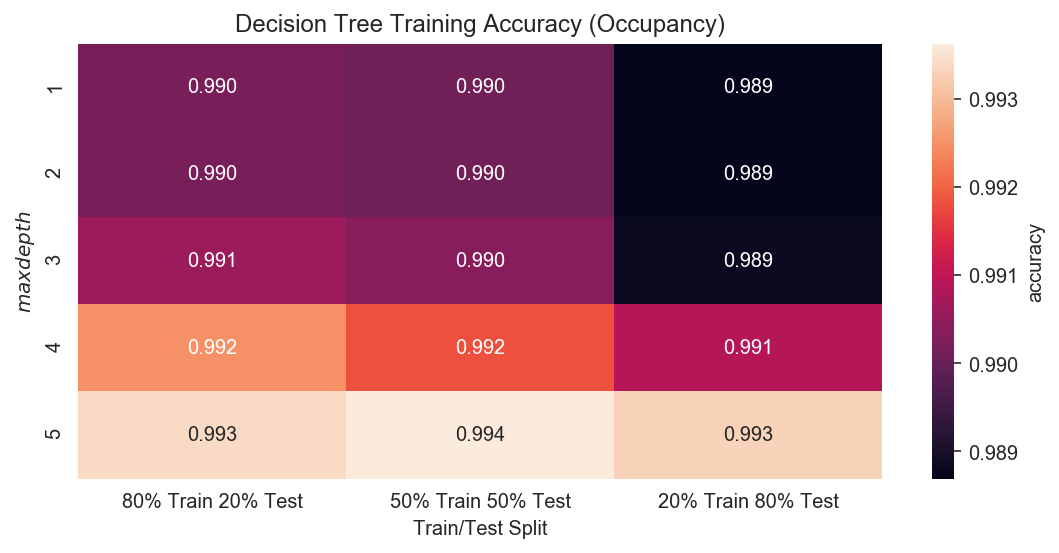

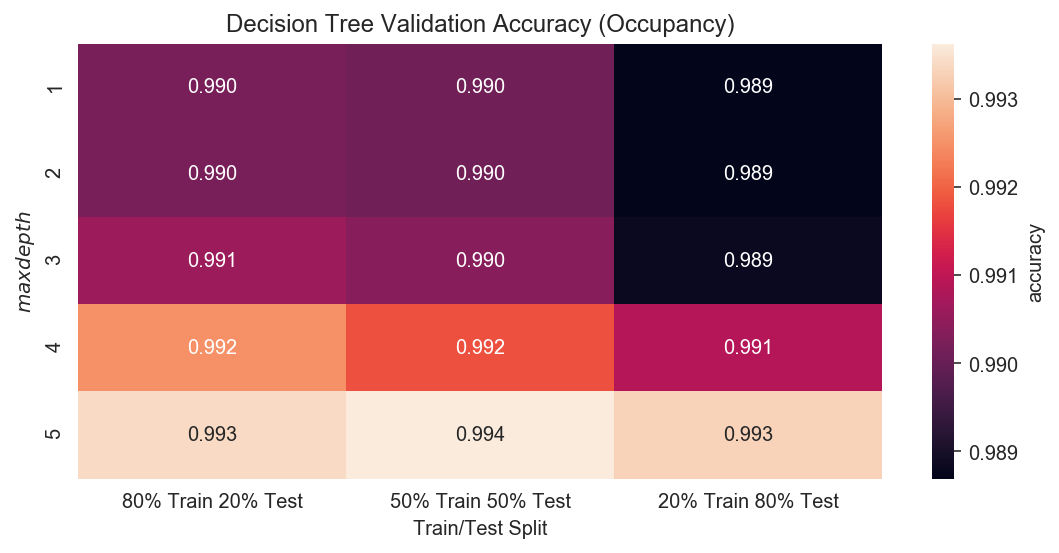

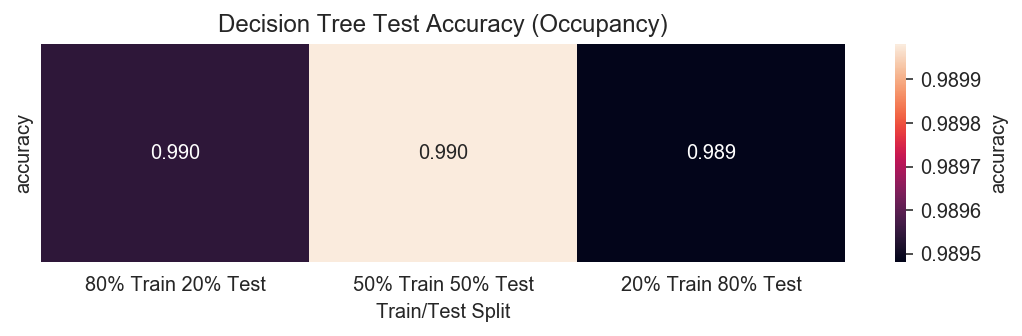

In [26]:
tree_occ = DecisionTree(X1_train_val_occ, Y1_train_val_occ,X2_train_val_occ, Y2_train_val_occ,
            X3_train_val_occ, Y3_train_val_occ,X1_test_occ, Y1_test_occ, 
            X2_test_occ, Y2_test_occ,X3_test_occ, Y3_test_occ,
            'Decision Tree Training Accuracy (Occupancy)', 
            'Decision Tree Validation Accuracy (Occupancy)', 
            'Decision Tree Test Accuracy (Occupancy)')

In [27]:
#Fill with Output After Fitting Data 
tree_overall_average.append(np.mean(list(tree_occ.values())))

hold = [] 
hold.append(tree_occ['80/20 Split Train'])
hold.append(tree_occ['80/20 Split Validation'])
hold.append(tree_occ['80/20 Split Test'])
tree1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(tree_occ['50/50 Split Train'])
hold.append(tree_occ['50/50 Split Validation'])
hold.append(tree_occ['50/50 Split Test'])
tree2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(tree_occ['20/80 Split Train'])
hold.append(tree_occ['20/80 Split Validation'])
hold.append(tree_occ['20/80 Split Test'])
tree3_average.append(np.mean(np.array(hold)))

tree_occ_average_test = np.mean(np.array(hold))

## Neural Network 

### Import Packages

In [28]:
from sklearn.neural_network import MLPClassifier

### Implementation

In [29]:
def draw_heatmap_perceptron(acc, acc_desc, activation_list, split):
    plt.figure(figsize = (9,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=activation_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Train/Test Split', ylabel='$activation$')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
def draw_heatmap_perceptron_test(acc, acc_desc, split):
    plt.figure(figsize = (9,2))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels='')
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Train/Test Split', ylabel='accuracy')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
#Multi-Layer Perceptron (Neural Net) Classifier with Cross-Validation of 3
def NeuralNet(X1_train_pred, Y1_train_val, X2_train_pred, Y2_train_val, X3_train_pred, Y3_train_val,
               X1_test, Y1_test, X2_test, Y2_test, X3_test, Y3_test, title1, title2, title3):
    
    NN = MLPClassifier(learning_rate_init = 0.02,max_iter = 2000)
    activation = ['identity','logistic','tanh','relu']
    train_test_split = ['80% Train 20% Test', '50% Train 50% Test','20% Train 80% Test']
    
    grid_search_1 = GridSearchCV(NN,{'activation':activation}, cv=3,return_train_score=True, iid=False)
    grid_search_1.fit(X1_train_pred,Y1_train_val)
    
    grid_search_2 = GridSearchCV(NN,{'activation':activation}, cv=3,return_train_score=True, iid=False)
    grid_search_2.fit(X2_train_pred,Y2_train_val)
    
    grid_search_3 = GridSearchCV(NN,{'activation':activation}, cv=3,return_train_score=True, iid=False)
    grid_search_3.fit(X3_train_pred,Y3_train_val)
    
    #Reporting Accuracy 
    
    #TRAIN 
    train_acc_1 = grid_search_1.cv_results_['mean_train_score'].reshape(4,1)
    train_acc_2 = grid_search_2.cv_results_['mean_train_score'].reshape(4,1)
    train_acc_3 = grid_search_3.cv_results_['mean_train_score'].reshape(4,1)
    
    train_acc = np.array([[train_acc_1],[train_acc_2],[train_acc_3]]).T 
    train_acc = train_acc.reshape(4,3)
    draw_heatmap_perceptron(train_acc,title1,activation,train_test_split)
    
    #VALIDATION 
    val_acc_1 = grid_search_1.cv_results_['mean_train_score'].reshape(4,1)
    val_acc_2 = grid_search_2.cv_results_['mean_train_score'].reshape(4,1)
    val_acc_3 = grid_search_3.cv_results_['mean_train_score'].reshape(4,1)
    
    val_acc = np.array([[val_acc_1],[val_acc_2],[val_acc_3]]).T 
    val_acc = val_acc.reshape(4,3)
    draw_heatmap_perceptron(val_acc,title2,activation,train_test_split)
    
    #TEST 
    
    #First Prediction
    numcorrect = 0
    pred_1 = grid_search_1.predict(X1_test)
    for i in range(len(pred_1)):
        if pred_1[i] != Y1_test.iloc[i]:
            numcorrect += 1
    test_acc_1 = 1-(numcorrect / len(pred_1))
    
    #Second Prediction 
    numcorrect = 0
    pred_2 = grid_search_2.predict(X2_test)
    for i in range(len(pred_2)):
        if pred_2[i] != Y2_test.iloc[i]:
            numcorrect += 1
    test_acc_2 = 1-(numcorrect / len(pred_2))
    
    #Third Prediction
    numcorrect = 0
    pred_3 = grid_search_3.predict(X3_test)
    for i in range(len(pred_3)):
        if pred_3[i] != Y3_test.iloc[i]:
            numcorrect += 1
    test_acc_3 = 1-(numcorrect / len(pred_3))
    
    #Combine and Display
    test_acc = np.array([[test_acc_1], [test_acc_2], [test_acc_3]]).reshape(1,3)
    draw_heatmap_perceptron_test(test_acc, title3, train_test_split)
    
    #Handle Multiple Interations, Outputting Average Results 
    NNDict = {}
    NNDict['80/20 Split Train'] = np.mean(train_acc_1)
    NNDict['50/50 Split Train'] = np.mean(train_acc_2)
    NNDict['20/80 Split Train'] = np.mean(train_acc_3)
    NNDict['80/20 Split Validation'] = np.mean(val_acc_1)
    NNDict['50/50 Split Validation'] = np.mean(val_acc_2)
    NNDict['20/80 Split Validation'] = np.mean(val_acc_3)
    NNDict['80/20 Split Test'] = test_acc_1
    NNDict['50/50 Split Test'] = test_acc_2
    NNDict['20/80 Split Test'] = test_acc_3
    return NNDict

### Hold Results

In [30]:
NN_adult_average_test = 0
NN_wine_average_test = 0
NN_occ_average_test = 0 

NN_overall_average = []

#80/20 Split Average
NN1_average = []
#50/50 Split Average 
NN2_average = []
#20/80 Split Average 
NN3_average = []

### Results 

#### Neural Network - ADULT

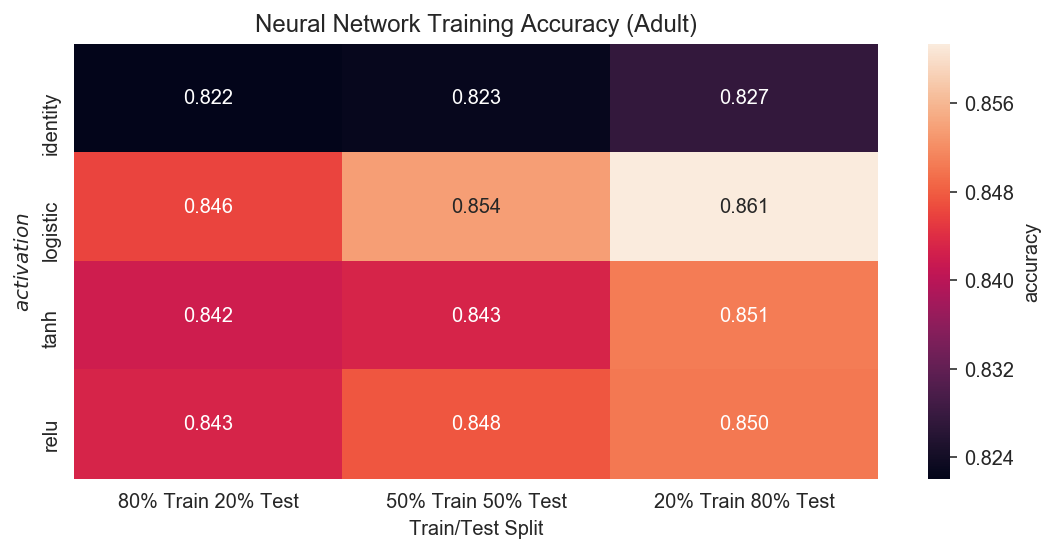

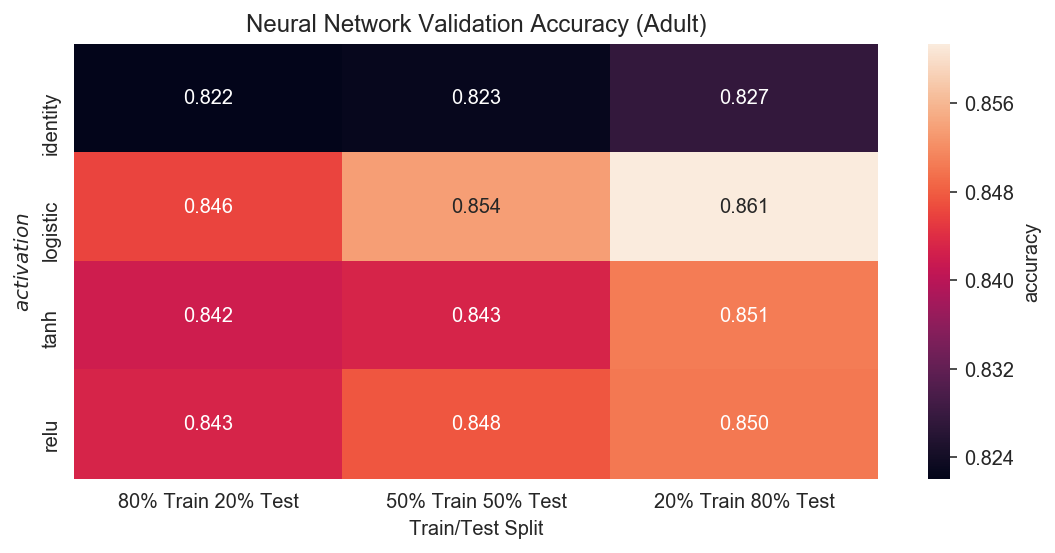

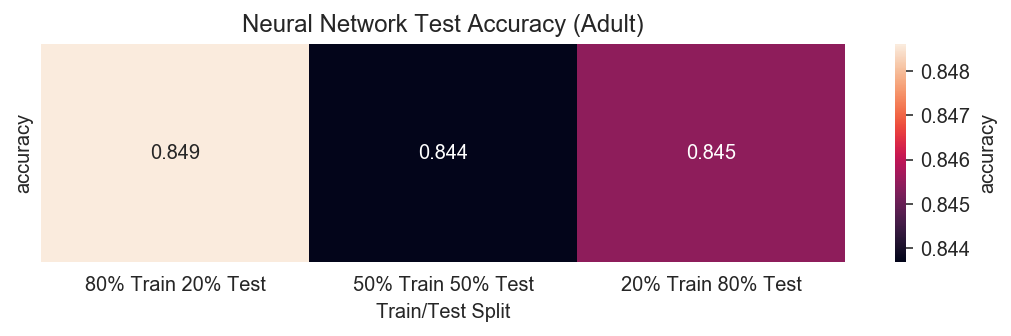

In [31]:
NN_adult = NeuralNet(X1_train_val_adult, Y1_train_val_adult,X2_train_val_adult,
                  Y2_train_val_adult,  X3_train_val_adult, Y3_train_val=Y3_train_val_adult,X1_test=X1_test_adult, Y1_test=Y1_test_adult,
                  X2_test=X2_test_adult,Y2_test=Y2_test_adult,X3_test=X3_test_adult, Y3_test=Y3_test_adult, 
                 title1='Neural Network Training Accuracy (Adult)', 
                 title2='Neural Network Validation Accuracy (Adult)', 
                 title3='Neural Network Test Accuracy (Adult)')

In [32]:
#Fill with Output After Fitting Data 
NN_overall_average.append(np.mean(list(NN_adult.values())))

hold = [] 
hold.append(NN_adult['80/20 Split Train'])
hold.append(NN_adult['80/20 Split Validation'])
hold.append(NN_adult['80/20 Split Test'])
NN1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(NN_adult['50/50 Split Train'])
hold.append(NN_adult['50/50 Split Validation'])
hold.append(NN_adult['50/50 Split Test'])
NN2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(NN_adult['20/80 Split Train'])
hold.append(NN_adult['20/80 Split Validation'])
hold.append(NN_adult['20/80 Split Test'])
NN3_average.append(np.mean(np.array(hold)))

NN_adult_average_test = np.mean(np.array(hold))

#### Neural Network - WINE

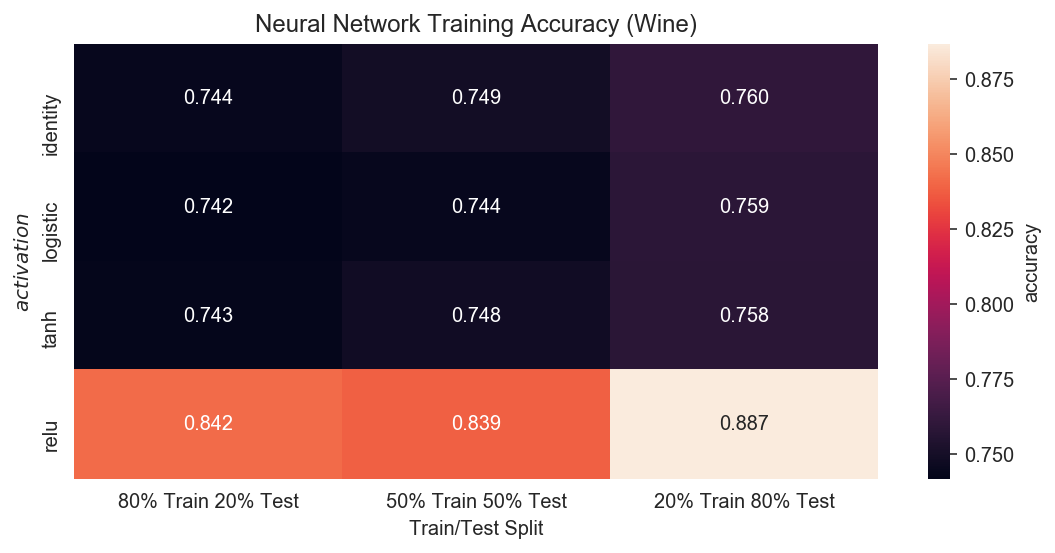

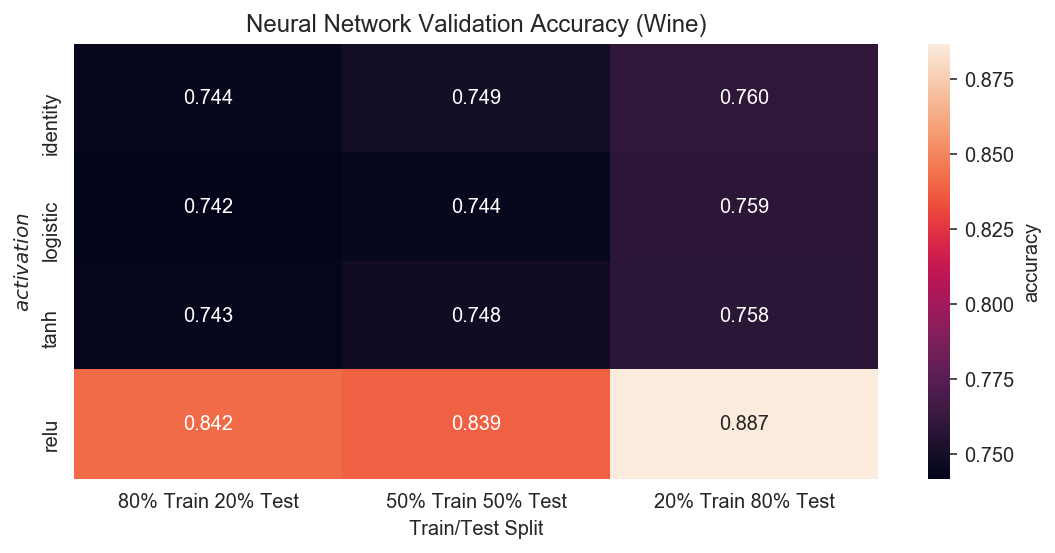

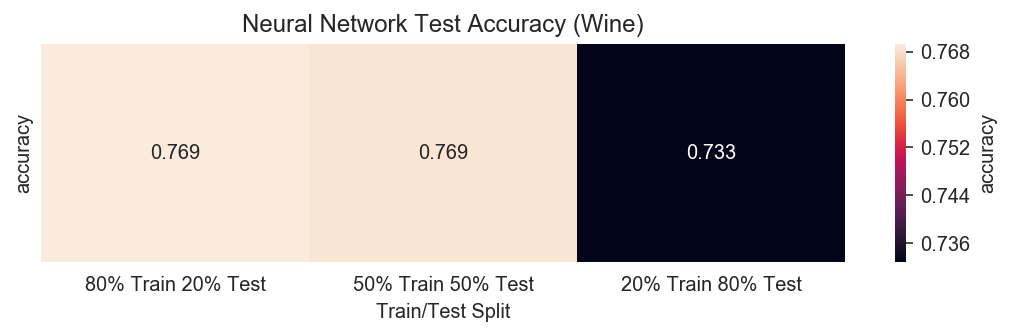

In [33]:
NN_wine = NeuralNet(X1_train_val_wine, Y1_train_val_wine,X2_train_val_wine,
                  Y2_train_val_wine,  X3_train_val_wine, Y3_train_val=Y3_train_val_wine,X1_test=X1_test_wine, Y1_test=Y1_test_wine,
                  X2_test=X2_test_wine,Y2_test=Y2_test_wine,X3_test=X3_test_wine, Y3_test=Y3_test_wine, 
                 title1='Neural Network Training Accuracy (Wine)', 
                 title2='Neural Network Validation Accuracy (Wine)', 
                 title3='Neural Network Test Accuracy (Wine)')

In [34]:
#Fill with Output After Fitting Data 
NN_overall_average.append(np.mean(list(NN_wine.values())))

hold = [] 
hold.append(NN_wine['80/20 Split Train'])
hold.append(NN_wine['80/20 Split Validation'])
hold.append(NN_wine['80/20 Split Test'])
NN1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(NN_wine['50/50 Split Train'])
hold.append(NN_wine['50/50 Split Validation'])
hold.append(NN_wine['50/50 Split Test'])
NN2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(NN_wine['20/80 Split Train'])
hold.append(NN_wine['20/80 Split Validation'])
hold.append(NN_wine['20/80 Split Test'])
NN3_average.append(np.mean(np.array(hold)))

NN_wine_average_test = np.mean(np.array(hold))

#### Neural Network - OCCUPANCY

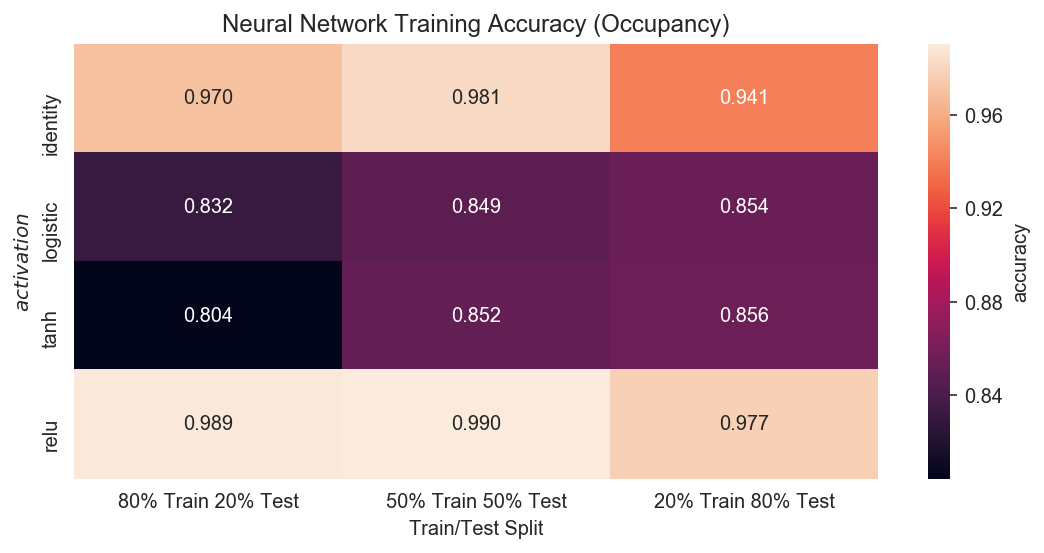

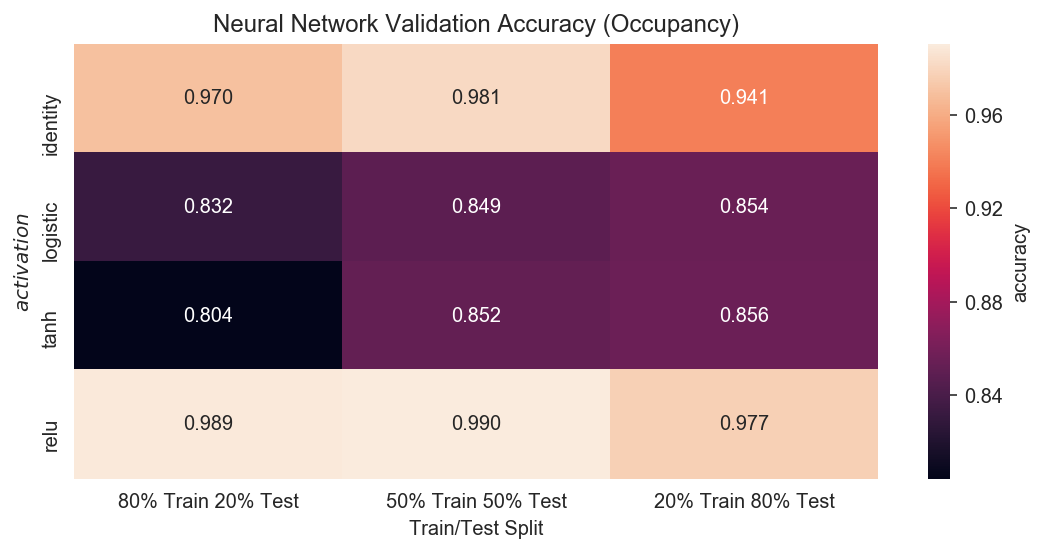

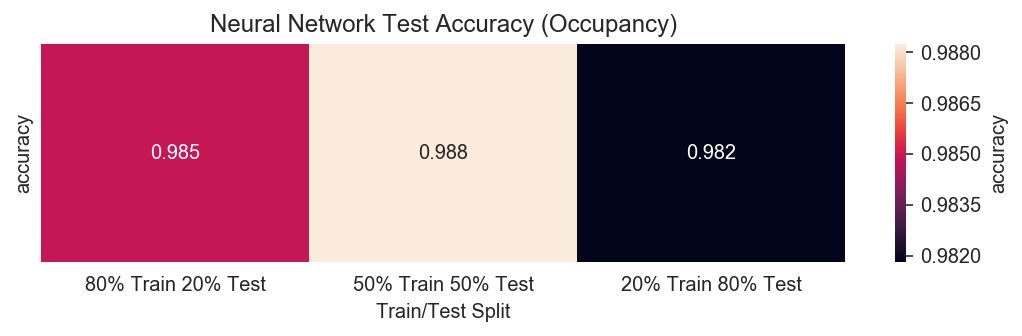

In [35]:
NN_occ = NeuralNet(X1_train_val_occ, Y1_train_val_occ,X2_train_val_occ, Y2_train_val_occ,
            X3_train_val_occ, Y3_train_val_occ,X1_test_occ, Y1_test_occ, 
            X2_test_occ, Y2_test_occ,X3_test_occ, Y3_test_occ,
            'Neural Network Training Accuracy (Occupancy)', 
            'Neural Network Validation Accuracy (Occupancy)', 
            'Neural Network Test Accuracy (Occupancy)')

In [36]:
#Fill with Output After Fitting Data 
NN_overall_average.append(np.mean(list(NN_occ.values())))

hold = [] 
hold.append(NN_occ['80/20 Split Train'])
hold.append(NN_occ['80/20 Split Validation'])
hold.append(NN_occ['80/20 Split Test'])
NN1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(NN_occ['50/50 Split Train'])
hold.append(NN_occ['50/50 Split Validation'])
hold.append(NN_occ['50/50 Split Test'])
NN2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(NN_occ['20/80 Split Train'])
hold.append(NN_occ['20/80 Split Validation'])
hold.append(NN_occ['20/80 Split Test'])
NN3_average.append(np.mean(np.array(hold)))

NN_occ_average_test = np.mean(np.array(hold))

## K-Nearest Neighbors

### Import Packages

In [37]:
from sklearn.neighbors import KNeighborsClassifier

### Implementation

In [38]:
def draw_heatmap_KNN(acc, acc_desc, k_list,split):
    plt.figure(figsize = (9,5))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=k_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Train/Test Split', ylabel='$activation$')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
def draw_heatmap_KNN_test(acc, acc_desc, split):
    plt.figure(figsize = (9,2))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels='')
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Train/Test Split', ylabel='accuracy')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
#KNN Classifier with Cross-Validation of 3
def KNN(X1_train_pred, Y1_train_val, X2_train_pred, Y2_train_val, X3_train_pred, Y3_train_val,\
               X1_test, Y1_test, X2_test, Y2_test, X3_test, Y3_test, title1, title2, title3):
    knn = KNeighborsClassifier()
    k_list = [1,2,3,4,5]
    train_test_split = ['80% Train 20% Test', '50% Train 50% Test','20% Train 80% Test']
    
    grid_search_1 = GridSearchCV(knn,{'n_neighbors':k_list}, cv=3,return_train_score=True,iid=False)
    grid_search_1.fit(X1_train_pred,Y1_train_val)
    
    grid_search_2 = GridSearchCV(knn,{'n_neighbors':k_list}, cv=3,return_train_score=True,iid=False)
    grid_search_2.fit(X2_train_pred,Y2_train_val)
    
    grid_search_3 = GridSearchCV(knn,{'n_neighbors':k_list}, cv=3,return_train_score=True,iid=False)
    grid_search_3.fit(X3_train_pred,Y3_train_val)
    
    #Reporting Accuracy 
    
    #TRAIN 
    train_acc_1 = grid_search_1.cv_results_['mean_train_score'].reshape(5,1)
    train_acc_2 = grid_search_2.cv_results_['mean_train_score'].reshape(5,1)
    train_acc_3 = grid_search_3.cv_results_['mean_train_score'].reshape(5,1)
    
    train_acc = np.array([[train_acc_1],[train_acc_2],[train_acc_3]]).T 
    train_acc = train_acc.reshape(5,3)
    draw_heatmap_KNN(train_acc,title1,k_list,train_test_split)
    
    #VALIDATION 
    val_acc_1 = grid_search_1.cv_results_['mean_train_score'].reshape(5,1)
    val_acc_2 = grid_search_2.cv_results_['mean_train_score'].reshape(5,1)
    val_acc_3 = grid_search_3.cv_results_['mean_train_score'].reshape(5,1)
    
    val_acc = np.array([[val_acc_1],[val_acc_2],[val_acc_3]]).T 
    val_acc = val_acc.reshape(5,3)
    draw_heatmap_KNN(val_acc,title2,k_list,train_test_split)
    
    #TEST 
    
    #First Prediction
    numcorrect = 0
    pred_1 = grid_search_1.predict(X1_test)
    for i in range(len(pred_1)):
        if pred_1[i] != Y1_test.iloc[i]:
            numcorrect += 1
    test_acc_1 = 1-(numcorrect / len(pred_1))
    
    #Second Prediction 
    numcorrect = 0
    pred_2 = grid_search_2.predict(X2_test)
    for i in range(len(pred_2)):
        if pred_2[i] != Y2_test.iloc[i]:
            numcorrect += 1
    test_acc_2 = 1-(numcorrect/ len(pred_2))
    
    #Third Prediction
    numcorrect = 0
    pred_3 = grid_search_3.predict(X3_test)
    for i in range(len(pred_3)):
        if pred_3[i] != Y3_test.iloc[i]:
            numcorrect += 1
    test_acc_3 = 1-(numcorrect / len(pred_3))
    
    #Combine and Display
    test_acc = np.array([[test_acc_1], [test_acc_2], [test_acc_3]]).reshape(1,3)
    draw_heatmap_KNN_test(test_acc, title3, train_test_split)
    
    #Handle Multiple Interations, Outputting Average Results 
    KNNDict = {}
    KNNDict['80/20 Split Train'] = np.mean(train_acc_1)
    KNNDict['50/50 Split Train'] = np.mean(train_acc_2)
    KNNDict['20/80 Split Train'] = np.mean(train_acc_3)
    KNNDict['80/20 Split Validation'] = np.mean(val_acc_1)
    KNNDict['50/50 Split Validation'] = np.mean(val_acc_2)
    KNNDict['20/80 Split Validation'] = np.mean(val_acc_3)
    KNNDict['80/20 Split Test'] = test_acc_1
    KNNDict['50/50 Split Test'] = test_acc_2
    KNNDict['20/80 Split Test'] = test_acc_3
    return KNNDict

### Hold Results

In [39]:
knn_adult_average_test = 0
knn_wine_average_test =0
knn_occ_average_test=0

knn_overall_average = []

knn1_average = []
knn2_average = []
knn3_average = []

### Results

#### KNN: ADULT

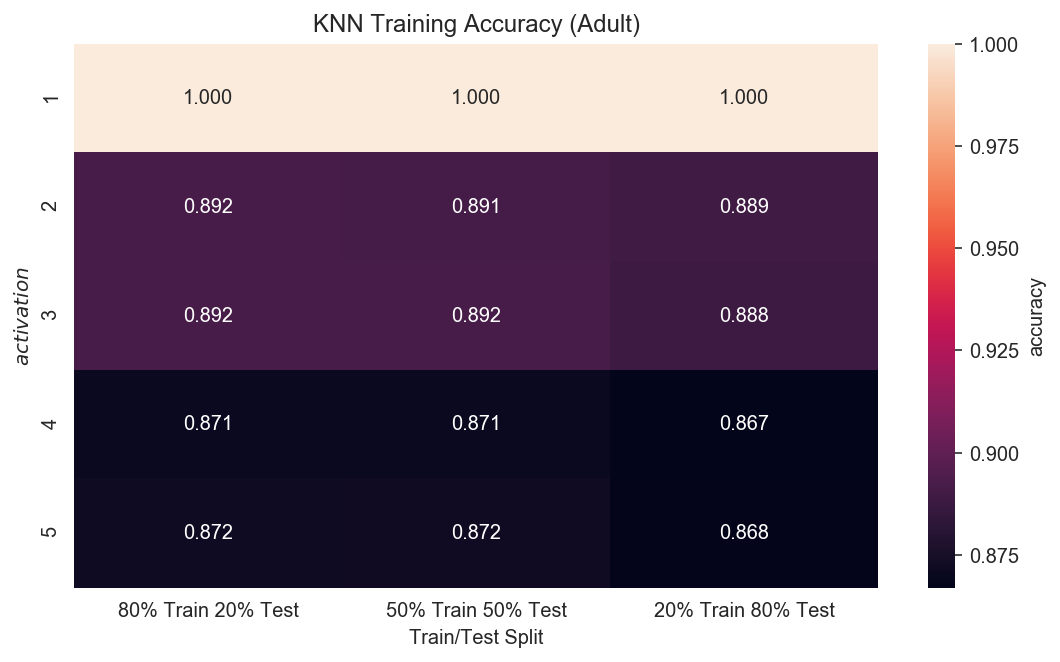

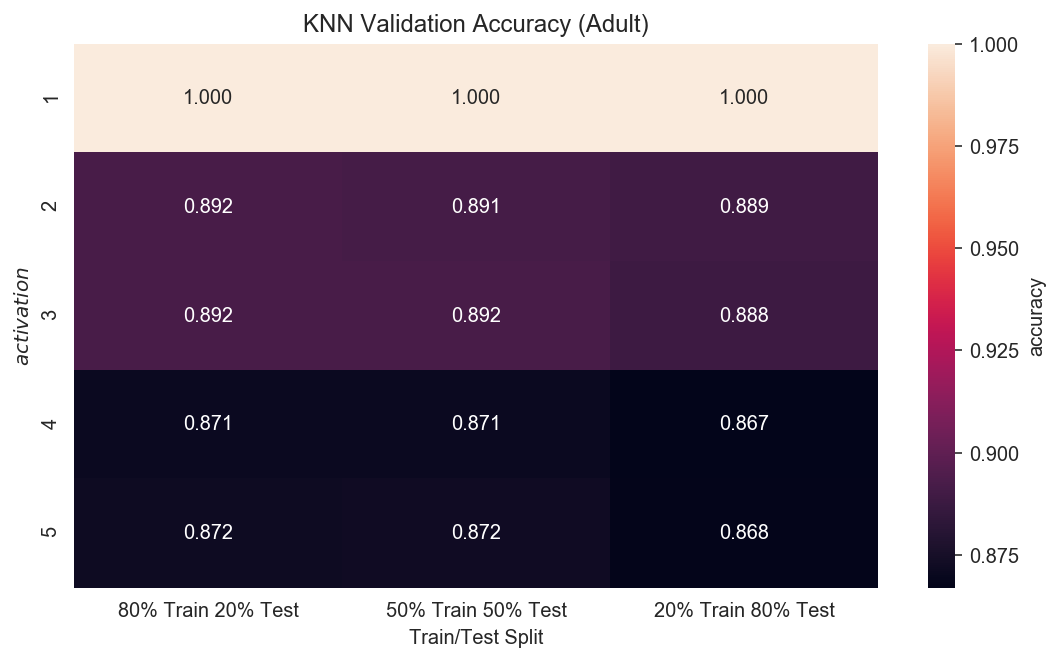

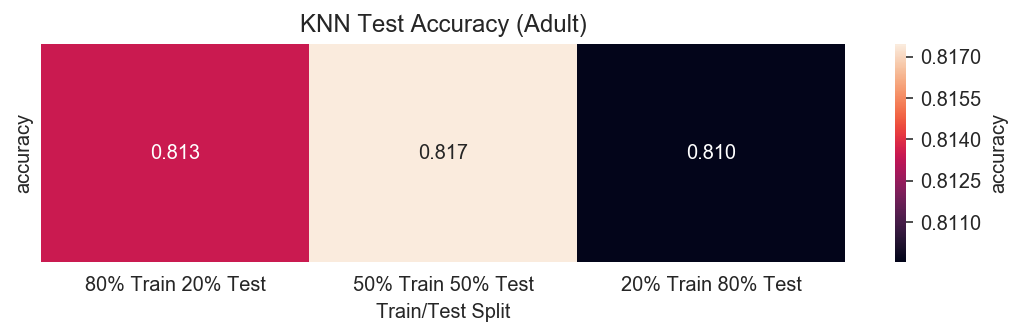

In [40]:
knn_adult = KNN(X1_train_val_adult, Y1_train_val_adult,X2_train_val_adult,
                  Y2_train_val_adult,  X3_train_val_adult, Y3_train_val=Y3_train_val_adult,X1_test=X1_test_adult, Y1_test=Y1_test_adult,
                  X2_test=X2_test_adult,Y2_test=Y2_test_adult,X3_test=X3_test_adult, Y3_test=Y3_test_adult, 
                 title1='KNN Training Accuracy (Adult)', 
                 title2='KNN Validation Accuracy (Adult)', 
                 title3='KNN Test Accuracy (Adult)')

In [41]:
#Fill with Output After Fitting Data 
knn_overall_average.append(np.mean(list(knn_adult.values())))

hold = [] 
hold.append(knn_adult['80/20 Split Train'])
hold.append(knn_adult['80/20 Split Validation'])
hold.append(knn_adult['80/20 Split Test'])
knn1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(knn_adult['50/50 Split Train'])
hold.append(knn_adult['50/50 Split Validation'])
hold.append(knn_adult['50/50 Split Test'])
knn2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(knn_adult['20/80 Split Train'])
hold.append(knn_adult['20/80 Split Validation'])
hold.append(knn_adult['20/80 Split Test'])
knn3_average.append(np.mean(np.array(hold)))

knn_adult_average_test = np.mean(np.array(hold))

#### KNN: WINE

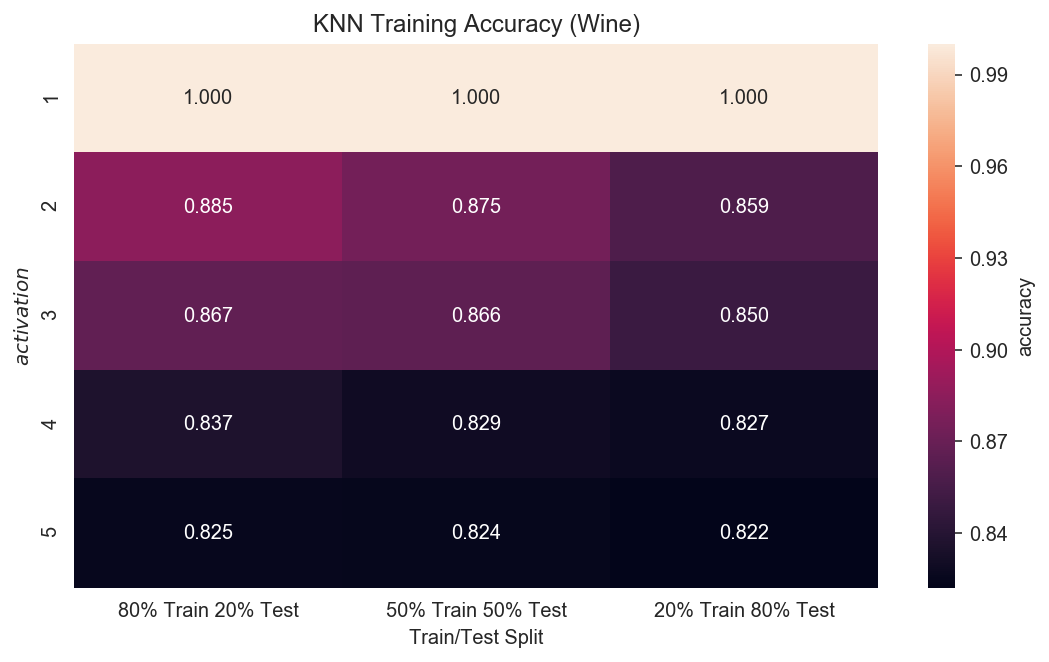

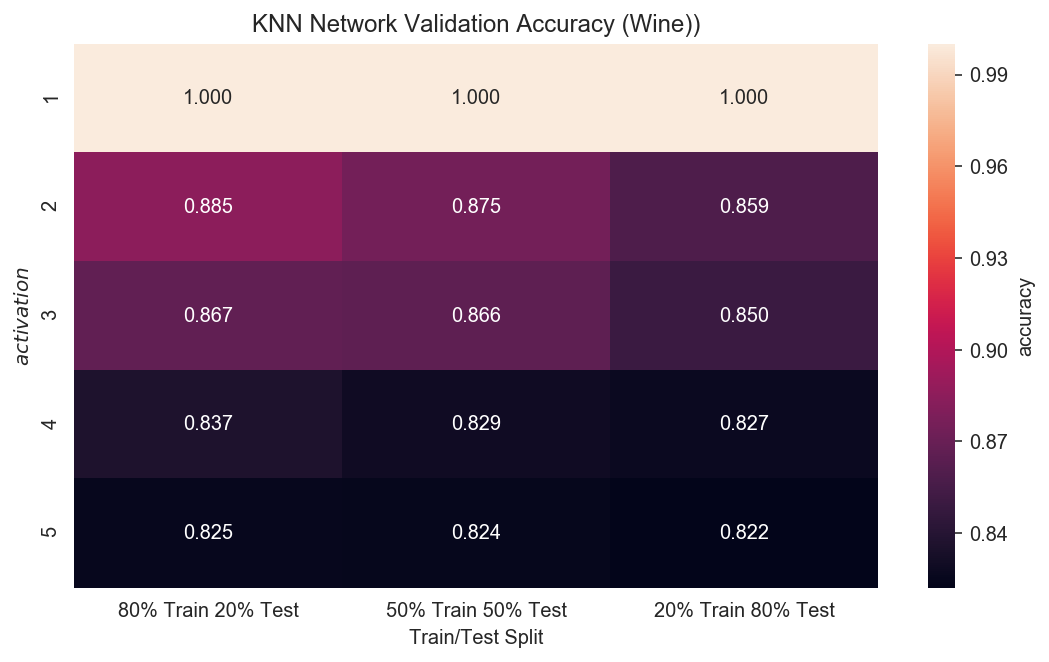

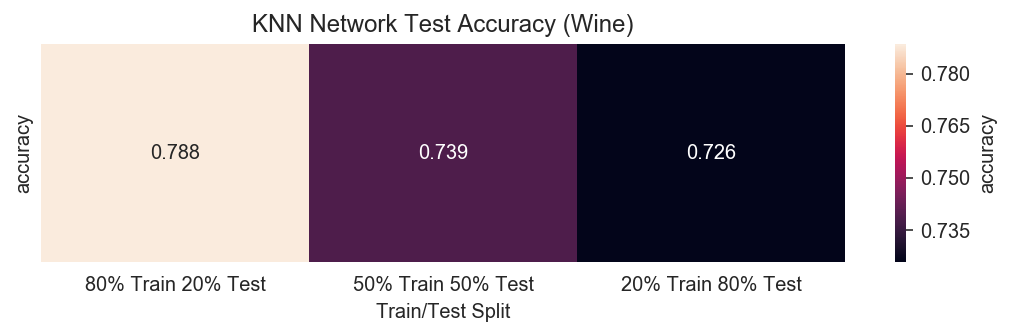

In [42]:
knn_wine = KNN(X1_train_val_wine, Y1_train_val_wine,X2_train_val_wine,
                  Y2_train_val_wine,  X3_train_val_wine, Y3_train_val=Y3_train_val_wine,X1_test=X1_test_wine, Y1_test=Y1_test_wine,
                  X2_test=X2_test_wine,Y2_test=Y2_test_wine,X3_test=X3_test_wine, Y3_test=Y3_test_wine, 
                 title1='KNN Training Accuracy (Wine)', 
                 title2='KNN Network Validation Accuracy (Wine))', 
                 title3='KNN Network Test Accuracy (Wine)')

In [43]:
#Fill with Output After Fitting Data 
knn_overall_average.append(np.mean(list(knn_wine.values())))

hold = [] 
hold.append(knn_wine['80/20 Split Train'])
hold.append(knn_wine['80/20 Split Validation'])
hold.append(knn_wine['80/20 Split Test'])
knn1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(knn_wine['50/50 Split Train'])
hold.append(knn_wine['50/50 Split Validation'])
hold.append(knn_wine['50/50 Split Test'])
knn2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(knn_wine['20/80 Split Train'])
hold.append(knn_wine['20/80 Split Validation'])
hold.append(knn_wine['20/80 Split Test'])
knn3_average.append(np.mean(np.array(hold)))

knn_wine_average_test = np.mean(np.array(hold))

#### KNN: OCCUPANCY

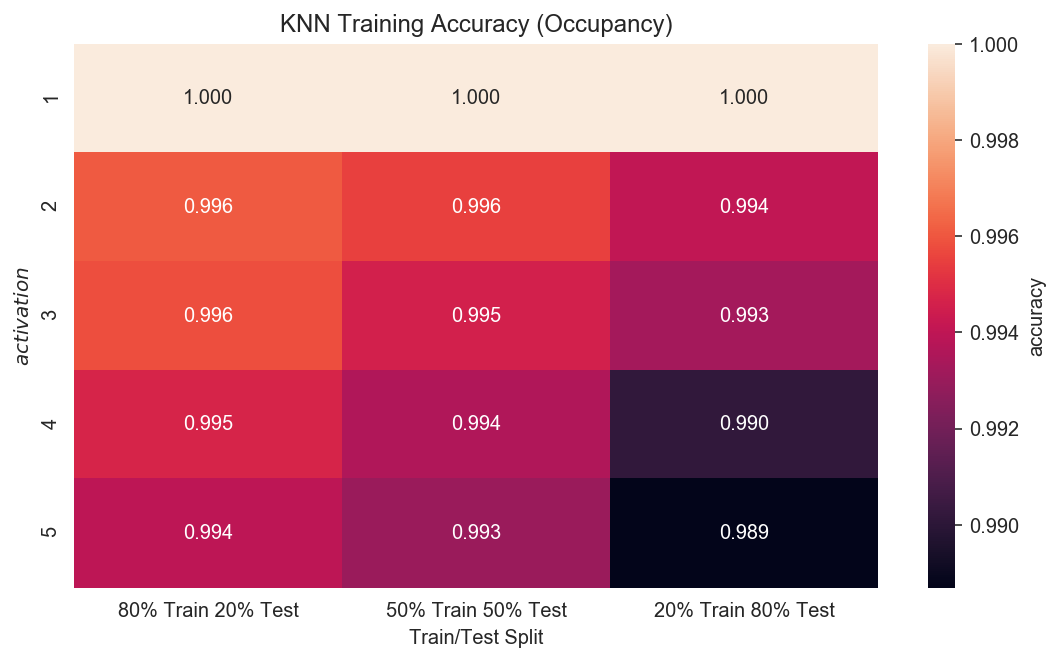

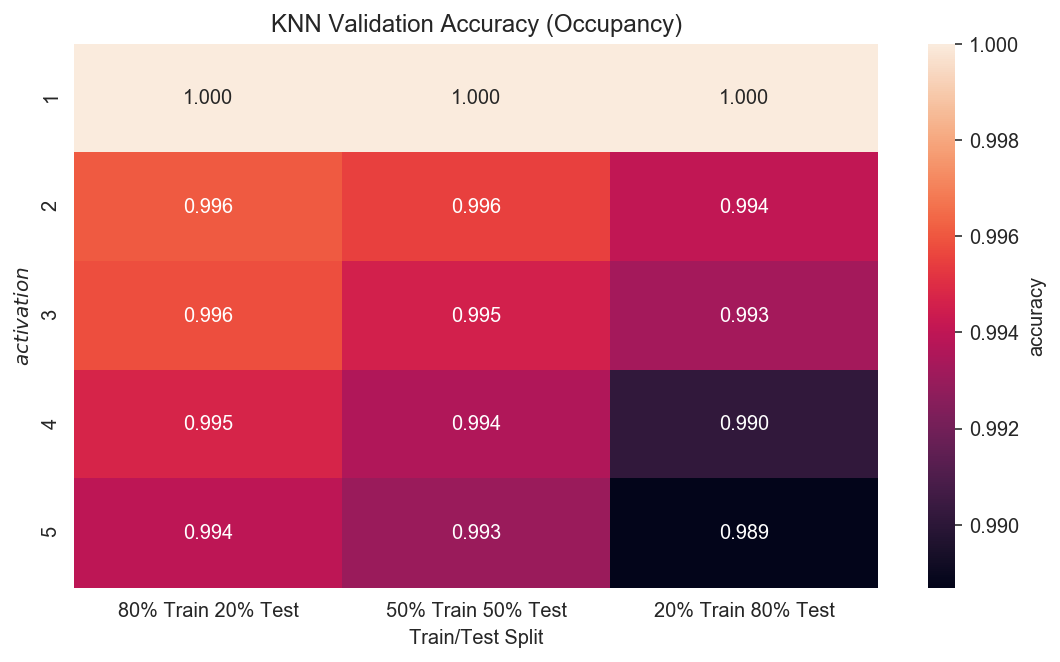

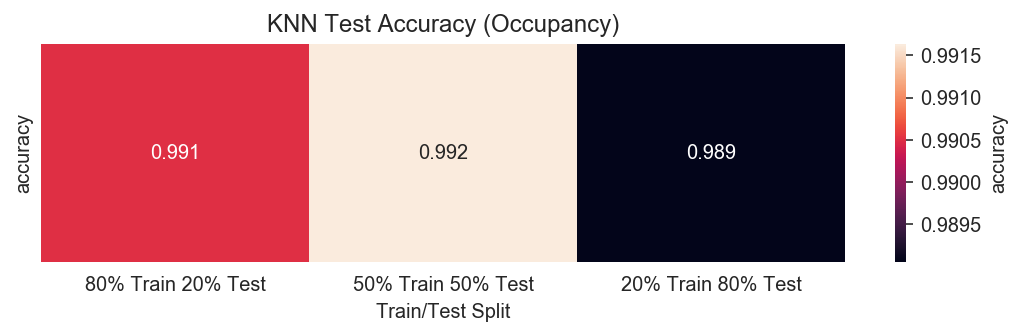

In [44]:
knn_occ = KNN(X1_train_val_occ, Y1_train_val_occ,X2_train_val_occ, Y2_train_val_occ,
            X3_train_val_occ, Y3_train_val_occ,X1_test_occ, Y1_test_occ, 
            X2_test_occ, Y2_test_occ,X3_test_occ, Y3_test_occ,
            'KNN Training Accuracy (Occupancy)', 
            'KNN Validation Accuracy (Occupancy)', 
            'KNN Test Accuracy (Occupancy)')

In [45]:
#Fill with Output After Fitting Data 
knn_overall_average.append(np.mean(list(knn_occ.values())))

hold = [] 
hold.append(knn_occ['80/20 Split Train'])
hold.append(knn_occ['80/20 Split Validation'])
hold.append(knn_occ['80/20 Split Test'])
knn1_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(knn_occ['50/50 Split Train'])
hold.append(knn_occ['50/50 Split Validation'])
hold.append(knn_occ['50/50 Split Test'])
knn2_average.append(np.mean(np.array(hold)))

hold = [] 
hold.append(knn_occ['20/80 Split Train'])
hold.append(knn_occ['20/80 Split Validation'])
hold.append(knn_occ['20/80 Split Test'])
knn3_average.append(np.mean(np.array(hold)))

knn_occ_average_test = np.mean(np.array(hold))

## Conclusion

In [46]:
#Combine Average Test Results for Each Classifier, by Each Dataset 
adult_result = [LR_adult_average_test,tree_adult_average_test,NN_adult_average_test,knn_adult_average_test]
wine_result = [LR_wine_average_test,tree_wine_average_test,NN_wine_average_test, knn_wine_average_test]
occ_result = [LR_occ_average_test,tree_occ_average_test,NN_occ_average_test,knn_occ_average_test]

print('Adult:',['%.2f' % elem for elem in adult_result]) 
print('Wine:',['%.2f' % elem for elem in wine_result]) 
print('Occupancy:',['%.2f' % elem for elem in occ_result]) 

Adult: ['0.81', '0.84', '0.85', '0.87']
Wine: ['0.72', '0.74', '0.77', '0.82']
Occupancy: ['0.99', '0.99', '0.93', '0.99']


In [47]:
#Combine Average Test Results for Each Classifier, Averaged Over All Datasets
overall_result = [np.mean(LR_overall_average),np.mean(tree_overall_average),np.mean(NN_overall_average),np.mean(knn_overall_average)]

print('Overall Average Accuracy for Each Classifier:',['%.2f' % elem for elem in overall_result])

Overall Average Accuracy for Each Classifier: ['0.87', '0.85', '0.85', '0.90']


In [48]:
#Combine Average Test Results for Each Dataset, by Each Classifier
LR_result = [(LR_adult_average_test),(LR_wine_average_test),(LR_occ_average_test)]
tree_result = [(tree_adult_average_test),(tree_wine_average_test),(tree_occ_average_test)]
NN_result = [(NN_adult_average_test),(NN_wine_average_test),(NN_occ_average_test)]
knn_result = [(knn_adult_average_test),(knn_wine_average_test),(knn_occ_average_test)]

print('Logistic Regression:',['%.2f' % elem for elem in LR_result])
print('Decision Tree:',['%.2f' % elem for elem in LR_result])
print('Neural Network:',['%.2f' % elem for elem in NN_result])
print('K-Nearest Neighbors:',['%.2f' % elem for elem in knn_result])

Logistic Regression: ['0.81', '0.72', '0.99']
Decision Tree: ['0.81', '0.72', '0.99']
Neural Network: ['0.85', '0.77', '0.93']
K-Nearest Neighbors: ['0.87', '0.82', '0.99']


In [49]:
#Combine Average Test Results for Each Dataset, by Each Partition 
adult_partition_result = np.mean([LR_adult['80/20 Split Test'],LR_adult['50/50 Split Test'],LR_adult['20/80 Split Test'],tree_adult['80/20 Split Test'],tree_adult['50/50 Split Test'],tree_adult['20/80 Split Test'],NN_adult['80/20 Split Test'],NN_adult['50/50 Split Test'],NN_adult['20/80 Split Test'],knn_adult['80/20 Split Test'],knn_adult['50/50 Split Test'],knn_adult['20/80 Split Test']])
wine_partition_result = np.mean([LR_wine['80/20 Split Test'],LR_wine['50/50 Split Test'],LR_wine['20/80 Split Test'],tree_wine['80/20 Split Test'],tree_wine['50/50 Split Test'],tree_wine['20/80 Split Test'],NN_wine['80/20 Split Test'],NN_wine['50/50 Split Test'],NN_wine['20/80 Split Test'],knn_wine['80/20 Split Test'],knn_wine['50/50 Split Test'],knn_wine['20/80 Split Test']])
occ_partition_result = np.mean([LR_occ['80/20 Split Test'],LR_occ['50/50 Split Test'],LR_occ['20/80 Split Test'],tree_occ['80/20 Split Test'],tree_occ['50/50 Split Test'],tree_occ['20/80 Split Test'],NN_occ['80/20 Split Test'],NN_occ['50/50 Split Test'],NN_occ['20/80 Split Test'],knn_occ['80/20 Split Test'],knn_occ['50/50 Split Test'],knn_occ['20/80 Split Test']])

print('Adult Average Accuracy over All Partitions:',np.round(adult_partition_result,2))
print('Wine Average Accuracy over All Partitions:',np.round(wine_partition_result,2))
print('Occupancy Average Accuracy over All Partitions:',np.round(occ_partition_result,2))

Adult Average Accuracy over All Partitions: 0.83
Wine Average Accuracy over All Partitions: 0.74
Occupancy Average Accuracy over All Partitions: 0.99


In [50]:
#Combine Average Test Results for Each Partition, by Each Dataset 
partition_80_20 = np.mean([LR_adult['80/20 Split Test'],tree_adult['80/20 Split Test'],NN_adult['80/20 Split Test'],knn_adult['80/20 Split Test'],LR_wine['80/20 Split Test'],tree_wine['80/20 Split Test'],NN_wine['80/20 Split Test'],knn_wine['80/20 Split Test'],LR_occ['80/20 Split Test'],tree_occ['80/20 Split Test'],NN_occ['80/20 Split Test'],knn_occ['80/20 Split Test']])
partition_50_50 = np.mean([LR_adult['50/50 Split Test'],tree_adult['50/50 Split Test'],NN_adult['50/50 Split Test'],knn_adult['50/50 Split Test'],LR_wine['50/50 Split Test'],tree_wine['50/50 Split Test'],NN_wine['50/50 Split Test'],knn_wine['50/50 Split Test'],LR_occ['50/50 Split Test'],tree_occ['50/50 Split Test'],NN_occ['50/50 Split Test'],knn_occ['50/50 Split Test']])
partition_20_80 = np.mean([LR_adult['20/80 Split Test'],tree_adult['20/80 Split Test'],NN_adult['20/80 Split Test'],knn_adult['20/80 Split Test'],LR_wine['20/80 Split Test'],tree_wine['20/80 Split Test'],NN_wine['20/80 Split Test'],knn_wine['20/80 Split Test'],LR_occ['20/80 Split Test'],tree_occ['20/80 Split Test'],NN_occ['20/80 Split Test'],knn_occ['20/80 Split Test']])

print('80/20 Average Split Performance:',np.round(partition_80_20,2))
print('50/50 Average Split Performance:',np.round(partition_50_50,2))
print('20/80 Average Split Performance:',np.round(partition_20_80,2))

80/20 Average Split Performance: 0.86
50/50 Average Split Performance: 0.85
20/80 Average Split Performance: 0.85
